In [1]:
# Notebook Summary:

# V.History: 
# Date Last Modified: 14 May 2025
# Date Last Modified: 27 Jul 2025 #Added a logic for automatically creating the dummy variables

#--------------------------------------------------------------------------------------------------
'''
    This is a LightGBM model validation trained on 58 (45 determinands + Spatial parameters) input parameters. The notebook calls the 
    pre-trained model (with 35+ million records of 24 years of WQ data for England from the 
    Environment Agency archives) from a pickle file under the pkls subdirectory and computes 
    the given input format using the encoder files under the pkls subdirectory & for temporal 
    features . It then predicts the orthophosphate for the given input data. The following 
    pickles for all encoders need to be used while using a pre-trained model for predictions.

    Following are the label encoders created newly:
        ==============================================================================
        Feature name                     Name of the Encoded pickle file             *
        ==============================================================================
        1. isComplianceSample            - encoder_isComplianceSample.pkl            *
        2. purpose_name                  - encoder_purpose_name.pkl                  *
        3. determinand_unit_name         - encoder_determinand_unit_name.pkl         *
        4. samplingPoint_notation        - encoder_samplingPoint_notation.pkl        *
        5. Season                        - encoder_Season.pkl                        *
        6. Day_of_Week                   - encoder_Day_of_Week.pkl                   *
        7. Month_of_Year                 - encoder_Month_of_Year.pkl                 *
        8. longitude                     - encoder_longitude.pkl                     *
        9. latitude                      - encoder_latitude.pkl                      *
        ==============================================================================
   
    Auto computed Temporal features:
        1. Season
        2. Day_of_week
        3. Month_of_Year
        
    Date: May 15, 2025

    This step enables the model to recognise compliance samples, their purposes, and the varied 
    unit names of Determinands.
'''
#--------------------------------------------------------------------------------------------------


#--------------------------------------------------------------------------------------------------
#Pre-Requisite : 
    #Kernel TensorFlow 2-11 (ipykernel) is required to run this notebook 
    #Required TensorFloa Kernel with python version - Python 3.10.15 and its 
    #compatible Numpy , ScikitLearn libraries

#Old Name: 16_NB_Pred_Pt2_v9Test_Ortho2959_SpatioTemp_LGMB.ipynb
#--------------------------------------------------------------------------------------------------

'''
    Intro Section
'''

'\n    Intro Section\n'

# '''
    Info Section
'''

# This requires Tersorflow 2-11 Kernel or Python 3 kernel

'''
01. Conda Environmant activation
================================
    - To activate your environment, use                                                                                                                                          
        $ conda activate your_environment_name

    - To deactivate an active environment, use
        $ conda deactivate
'''

'''
02. Model name: #Light Gradient Boosting Prediction model for Orthophosphate, Following are the tracked Metrics: 
================================================================================================================
    1. RMSE     - Root Mean Squared Error
    2. NRMSE    - Normalised Root Mean Squared Error 
    3. MAE      - Mean Absolute Error
    4. MSE      - Mean Squared Error
    5. SHAP     - Violin Plot, Summary Plot, History Plot [Explainable AI]
'''

'''
03. Acceptable INPUT Parameters to the Model:
=============================================

    References and Known limitations:
    - Refer to the Environmental Agency Archive for information on WQ Notations. The model uses these notations as 
      per EA's standard denotations.
      
    - Please note, if an observation has a prefix of < or > to indicate a 'limit of detection', remove these 
      and provide the numerical value as obtained. Currently, the model works based on the weightage 
      for a given numerical value. 
        00. samplingPoint_notation         - Sampling point location where the samples taken from

    - Following table illustrates the Input variables the model accepts.
      The Notation ID's for the Determinands ranges any number between 1 to 9995
      Name and Descriptions are taken as such from the EA's WQ standards
    
        01. sampleDateOnly                - Dates the sample is taken from. Acceptable format: dd/mm/yyyy
        02. samplingPoint_easting         - Easting (BNG Cordinates)
        03. samplingPoint_northing        - Northing (BNG Cordinates)
        04. purpose_name                  - Purpose Name (Ex: 'PLANNED INVESTIGATION (LOCAL MONITORING)')
        05. isComplianceSample            - Is this a compliance sample or not (Ex: TRUE or FALSE)
    
        SNO Notation ID    Name                 Description
        ===================================================
        24. 61             pH                   pH
        46. 68             Turbidity            Turbidity
        22. 76             Temp Water           Temperature of Water
        45. 82             O Dissolved          Oxygen, Dissolved : (Laboratory) as O2
        08. 85             BOD ATU              BOD : 5 Day ATU
        02. 111            Ammonia(N)           Ammoniacal Nitrogen as N
        21. 113            N Organic            Nitrogen, Organic as N
        20. 114            N-Kjeldahl           Nitrogen, Kjeldahl as N
        01. 116            N Oxidised           Nitrogen, Total Oxidised as N
        03. 117            Nitrate-N            Nitrate as N
        04. 118            Nitrite-N            Nitrite as N
        05. 119            NH3 un-ion           Ammonia un-ionised as N
        09. 135            Sld Sus@105C         Solids, Suspended at 105 C
        27. 143            Sld NV@500C          Solids, non-volatile at 500 C
        13. 158            Hardness             Hardness, Total as CaCO3
        07. 162            Alky pH 4.5          Alkalinity to pH 4.5 as CaCO3
        10. 172            Chloride Ion         Chloride
        42. 175            Cyanide - CN         Cyanide as CN
        31. 177            Fluoride - F         Fluoride
        14. 182            SiO2 Rv              Silica, reactive as SiO2
        26. 183            Sulphate SO4         Sulphate as SO4
        18. 192            Phosphate            Phosphate :- {TIP}
        37. 205            Na- Filtered         Sodium, Dissolved
        29. 207            Sodium - Na          Sodium
        36. 209            K- Filtered          Potassium, Dissolved
        16. 211            Potassium- K         Potassium
        43. 235            Mg Filtered          Magnesium, Dissolved
        12. 237            Magnesium-Mg         Magnesium
        41. 239            Ca Filtered          Calcium, Dissolved
        11. 241            Calcium - Ca         Calcium
        23. 301            C - Org Filt         Carbon, Organic, Dissolved as C :- {DOC}
        15. 348            Phosphorus-P         Phosphorus, Total as P
        28. 461            DtrgtAncSyn          Detergents, Anionic
        30. 463            Dtrgt NncSyn         Detergents, Non-ionic
        35. 749            Phenols Mono         Phenols : Monohydric as Phenol
        44. 1181           WethPresTemp         Weather : Temperature
        40. 1183           WethPresPrec         Weather : Precipitation
        17. 3683           N Inorganic          Nitrogen, Total Inorganic : (Calculated)
        33. 6450           Cu Filtered          Copper, Dissolved
        34. 6455           Zinc - as Zn         Zinc
        39. 7859           SO4dis               Sulphate, Dissolved as SO4
        19. 9686           Nitrogen - N         Nitrogen, Total as N
        38. 9856           OrthophsFilt         Orthophosphate, Dissolved
        25. 9901           O Diss %sat          Oxygen, Dissolved, % Saturation
        06. 9924           Oxygen Diss          Oxygen, Dissolved as O2

        32. 77             Cond @ 25C           Conductivity at 25 C

    - Please note, following parameters can be supplied if available

        SNO Notation ID    Name
        ===================================================
        53. 180            OrthoP     (Supplied to validate the model, but is not reqquired for model predictions. When running the model for obtaining predictions, please include with sequence number)
        54. 192            Phosphate  (optional)
        55. 348            Phosphorus (optional)
    
    - In the acceptable input variables, following are the Determinands complied to Section-82 Regulatory parameters (UK Net Zero Targets)

        Notation ID Description
        ===================================================
        119      Ammonia un-ionised as N
        9924     Oxygen, Dissolved as O2
        76       Temperature of Water 
        61       pH
        9901     Oxygen, Dissolved, % Saturation
        82       Oxygen, Dissolved : (Laboratory) as O2
        68       Turbidity

04. Samples considered for the Model Training:
    - This model currently considers samples only from surface water (river/running surface water).
    - It includes all samples under this category, including 'Reactive Monitoring Samples'.
    - The model eliminates sampling points with fewer than 100 observations over the past twenty-four years (2000 to 2024).
    
05. Input template:
    - The format of the input template for obtaining Orthophosphate predictions can be found in the 
      "BB1C_Phosphate_Orthophosphate_model/03_prediction_model/templates" folder, 
      file name: "input_template_orthop2959_pred_lgbm.csv". Sample values for Eastings, Northings, 
      Sampling point IDs, Purpose Names, and Unit of measure metrics are also available in the same folder.
 
'''

'''
06. Extensibility:
==================
    - The model predicts orthophosphate for a given sample data but currently cannot forecast based on past 
      historical trends. However, this capability can be implemented in the future with minimal effort by changing the lags.
    - Although this model currently predicts orthophosphate, it can also be used to predict over 900 P-Family Determinands 
      by adjusting the target parameter. This is a core benefit of the chemical-based (Agglomerative) cluster analysis.
    - The model uses 2% of orthophosphate data sampled over the last 24 years (2000 to 2024) from 22,000 sampling 
      points. However, there are 64,000 sampling points across England that the EA is monitoring for water quality. 
      Hence, this model can retrospectively predict orthophosphate concentrations for the remaining 42,000 sampling points.
    - Samples from May 2024 onwards were purposely excluded from the training database to address model drift and data drift later, 
      thereby improving or retaining accuracy.
    - The model's current accuracy level is MSE - 0.00123, MAE - 0.01, and NRMSE - 8%, surpassing the industry standard.
    - The model has implemented the SHAP framework to obtain reasons for a prediction, facilitating insights and actionable 
      items for water quality managers, decision-makers, and stakeholders to make informed decisions.
    - The SHAP outcomes from this model can be integrated into a Generative AI Agentic workflow to easily obtain actionable 
      insights and compare them with pollution incidents that occurred during the predicted orthophosphate period.
    - The model uses water quality samples observed from UK catchments over the last 24 years. Therefore, it does not require 
      additional data such as runoff, land use, or rainfall, as these effects are accurately reflected in the water quality database 
      the model was trained with. Adding such data might cause the model to overlearn redundant information.

'''

'''
    Info Section
'''

In [2]:
#Check python version compatibility 3.10 or above is required
!python -V
python_version=!(python --version 2>&1)
print (python_version)

Python 3.10.15
['Python 3.10.15']


In [3]:
#Begin CARD

'''
    Theme: BB1C - Predicting Phosphate / Orthophosphate in UK Catchments Using AIML Models.
    This notebook uses a pre-trained, LightGBM based Orthophosphate model for obtaining predictions
    Pasupathi N, Lead Data Scientist, Cognizant - UK.
'''

'''
    Begin CARD
'''

'\n    Begin CARD\n'

In [4]:
#Local variable declerations

# <<<FINAL Validation LIST OF FEATURES>>> Modified the "FINAL LIST OF FEATURES" (Total: 58 | 46 Params + 6 Sec-81 params + 6 Spatio Params)
optimal_feat_with_r_mon = ['samplingPoint_notation','samplingPoint_easting',
                           'samplingPoint_northing','purpose_name',
                           #'determinand_unit_name',
                           'isComplianceSample',
                           '116','111','117','118','119','9924','162','85','135','172',           #10
                           '241','237','158','182','211','3683','9686','114','113','76',          #10
                           '301','61','9901','183','143','461','207','463','177','6450',          #10
                           '6455','749','209','205','9856','7859','1183','239','175','235',       #10
                           '1181','82','68',                                                      #03
                           '180','192','348'                                                      #03
                           #'OrthoP','Phosphate','Phosphorus' Consider 61 - pH 17% corr
                          ]

#These dummy variables are used by the model to find patterns. Please keep them all set to zero, except 
#for 'determinand_unit_name_label_28', which should be set to one.
determinand_unit_lable = ['determinand_unit_name_label_0','determinand_unit_name_label_3','determinand_unit_name_label_4',
                          'determinand_unit_name_label_5','determinand_unit_name_label_6','determinand_unit_name_label_8',
                          'determinand_unit_name_label_10','determinand_unit_name_label_11','determinand_unit_name_label_12',
                          'determinand_unit_name_label_13','determinand_unit_name_label_14','determinand_unit_name_label_15',
                          'determinand_unit_name_label_16','determinand_unit_name_label_17','determinand_unit_name_label_18',
                          'determinand_unit_name_label_19','determinand_unit_name_label_20','determinand_unit_name_label_25',
                          'determinand_unit_name_label_27','determinand_unit_name_label_28','determinand_unit_name_label_30',
                          'determinand_unit_name_label_35','determinand_unit_name_label_37','determinand_unit_name_label_38',
                          'determinand_unit_name_label_40','determinand_unit_name_label_41','determinand_unit_name_label_47',
                          'determinand_unit_name_label_48','determinand_unit_name_label_54','determinand_unit_name_label_56',
                          'determinand_unit_name_label_57','determinand_unit_name_label_58','determinand_unit_name_label_60',
                          'determinand_unit_name_label_61','determinand_unit_name_label_64','determinand_unit_name_label_65',
                          'determinand_unit_name_label_66','determinand_unit_name_label_67']

#Added on 27 Jul 2025 (to autocreate dummies)
determinand_unit_value = [0,0,0,
                          0,0,0,
                          0,0,0,
                          0,0,0,
                          0,0,0,
                          0,0,0,
                          0,1,0,
                          0,0,0,
                          0,0,0,
                          0,0,0,
                          0,0,0,
                          0,0,0,
                          0,0]

#Combine the variables into a list
from itertools import chain
optimal_feat_with_r_mon = list(chain(optimal_feat_with_r_mon, 
                                     determinand_unit_lable))

#This steps removes duplicate item and retains the first one found
optimal_feat_with_r_mon = list(dict.fromkeys(optimal_feat_with_r_mon))

#Explainable Params for the SP NE-44400163, DEERNESS U/S PRIEST BURN, Wear & Tees area
#Website: https://environment.data.gov.uk/water-quality/view/sampling-point/NE-44400163?_all=true
validation_Set = ['samplingPoint_notation_label','samplingPoint_easting','samplingPoint_northing','purpose_name_label','determinand_unit_name_label',
                  'isComplianceSample_label',
                  'purpose_name_label', 
                  'longitude_label', 'latitude_label',
                  '61','76','77','111','116','117','118','119','162','180','9901','9924',
                  'Day_of_Month', 'Week_of_Year', 'Season_label','Day_of_Week_label','Month_of_Year_label' #Temporal params
                 ]

In [5]:
print(len(optimal_feat_with_r_mon))

89


In [6]:
#Local variable declerations

Section_82_Yes = [61,68,76,81,82,119,3169,3656,3976,5282,6872,7064,
                  7786,8153,8958,9261,9803,9901,9921,9924]

#Section_82_Unsure 11 Determinands
lstSection_82_Unsure = [152,153,159,162,5245,8467,8471,9087,9088,9089,9821]

#First 18 parameters using Pearson correlation for the Phosphate - Feb 27 2025
First_18_Pearson_Pt = [912,914,8128,384,1361,7245,1284,8648,6971,
                       947,6972,82,6453,8476,7668,81,6854,162,8504]

altitude = [5]

# 8 Determinands
temperature = [22, 24, 76, 1181, 3026, 6530, 8091, 8918]

orthoP = [180]
orthoPLike = [188, 191, 8068, 8755, 9398, 9856]

Phosphate = [192]
PhophateLike = [4127, 7315, 8504]


In [7]:
# Installing required libraries - for drawing sattelitte maps
! pip install geopandas  | grep -v 'Requirement already satisfied'
! pip install contextily  | grep -v 'Requirement already satisfied'
! pip install pyproj | grep -v 'Requirement already satisfied'
! pip install geodatasets --upgrade  | grep -v 'already satisfied'
! pip install osmnx  | grep -v 'already satisfied'
! pip install optuna | grep -v 'already'



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [8]:
#Steps to enable NVidia GPUs. Due to version compatibility, these did not work. 
#Documented these to try later if required. The speed of execution is pretty good with the VCPU 
#configuration of n1-highmem-64 (64 vCPUs, 416 GB RAM) computes.

#Step 1
# Installing required libraries - for version compatibility
#!pip install --force-reinstall numpy==2.1.3
#!pip install --force-reinstall numpy==1.24.0 

#Step 2
# Installing required libraries - for TensorFlow Kernel
#!pip install tensorflow tensorflow_decision_forests | grep -v 'already'
#!pip install --upgrade tensorflow tensorflow_decision_forests | grep -v 'already'

#!pip install --upgrade randomforestmodule
#from keras.utils import timeseries_dataset_from_array

#Step 3
# Installing required libraries
!pip install permetrics | grep -v 'Requirement already satisfied'

#Step 4
# Installing required libraries
#!pip install --ignore-installed --upgrade tensorflow 
#!pip install --upgrade scikit-learn | greb -v 'already'

#Step 5
# Installing required libraries
#!pip install --upgrade tensorflow  | grep -v 'already' Commented on 16 May 2025

#Step 6
# Installing required libraries
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

#Step 7
# Nvidia version check
#!nvidia-smi

#Step 8
# Installing required libraries for Cuda - Using Nvidia's GPU capability (applicable for GPU computes)
#! pip install \
#    --extra-index-url=https://pypi.nvidia.com \
#    "cudf-cu12==25.2.*" | grep -v 'already'

#Step 9
# Installing required libraries
#import cudf.pandas
#cudf.pandas.install()
#!conda list cuda-python

#!conda install -c nvidia cuda-python=12.8.0 y

#pip install --exists-action=i scikit-learn

#import cupy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [9]:
# First install required packages if needed
!pip install fuzzywuzzy python-Levenshtein | grep -v 'already'


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from permetrics.regression import RegressionMetric

import matplotlib.pyplot as plt

#Outlier Detection and Removal
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns

import os
import requests
import zipfile
import geopandas as gpd
import contextily as ctx
from pyproj import Transformer
import geodatasets
import matplotlib.cm as cm
import matplotlib.colors as colors
import osmnx as ox
from matplotlib.colors import LinearSegmentedColormap

import joblib
from pathlib import Path
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import warnings

'''
from IPython.display import display
pd.set_option("max_columns", None) # show all cols
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
'''

'''
    import required fields
'''

'\n    import required fields\n'

In [11]:
#function to display the system time
def showtime():
    import time
    from datetime import datetime
    
    t = time.localtime()
    d = datetime.now()
    current_time = time.strftime("%H:%M:%S", t)
    current_date = d.strftime("%d %B %Y")
    print(current_date, current_time)
    return()

In [12]:
#TESTING DUMMY OF DETERMINAND UNIT NAME's INFLUENCE - BEGIN
import statsmodels.api as sm
# Function to calculate VIF
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)


In [13]:
#User-Defined functions
def showtime():
    import time
    from datetime import datetime
    
    t = time.localtime()
    d = datetime.now()
    current_time = time.strftime("%H:%M:%S", t)
    current_date = d.strftime("%d %B %Y")
    print(current_date, current_time)
    return()

In [14]:
#Function to print column-wise total number of actual observations (ignores zeroes) for a given dataset
def find_non_zero_lt_100(data):
    num=0
    count_of_non_zero_lt_100 = []
    total_len = len(data)
    for i in data.columns:
        num += data[i][data[i]==0.0].count()
        count_of_non_zero = total_len - data[i][data[i]==0.0].count()
        #print (data[i].name, ' | ', count_of_zero)
        #if (i==192):
        if (count_of_non_zero<=100):
            print ('Determinand: ', i, ' has Total | Valid values', total_len, '|', count_of_non_zero )
            count_of_non_zero_lt_100.append(i) 

    return (count_of_non_zero_lt_100)

In [15]:
#Find sum of non-zero values
#print(print(np.count_nonzero(data==0)))
def find_non_zero(data):
    num=0
    total_len = len(data)
    for i in data.columns:
        num += data[i][data[i]==0.0].count()
        count_of_non_zero = total_len - data[i][data[i]==0.0].count()
        #print (data[i].name, ' | ', count_of_zero)
        #if (i==192):
        #if (count_of_non_zero>=1):
            #print ('Determinand: ', i, ' has Total | Valid values', total_len, '|', count_of_non_zero )
    #num
    len(data)
    return;

In [16]:
#save given data set as CSV file into a gcp folder
def savedata(tDF, tname, tpath = 'gcs://rdmai_dev_data/') :
    #tpath = 'gcs://rdmai_dev_data/'
    if (tpath!='gcs://rdmai_dev_data/RDMAI_1C_OrthoP_R1/08_Validation_Outcome/'):
        tclensed = 'cleansed/'
    else:
        tclensed = ''
    tDF.to_csv(tpath+tclensed+tname)
    return("saved, Location: ", tpath+tclensed+tname)


In [17]:
# Function to evaluate model metrics
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} RMSE: {rmse:.2f}")
    print(f"{model_name} R²: {r2:.2f}")
    return y_pred

# Function to evaluate model metrics (Advanced)
def evaluate_model_adv(model, X_test, y_test, model_name="Model", metrics_mode="Test"):            
    if model_name == 'Neural Network' :
        y_pred = model.predict(X_test).flatten()
    else:
        y_pred = model.predict(X_test)
    
    #Obtain metrics for the predicted values where the actual OrthoP is non-zeroes ONLY 
    if (metrics_mode=="validation"): 
        X_Merge = []
        X_Merge = pd.DataFrame(y_test)
        X_Merge['Predicted_OrthoP'] = y_pred
        if (len(X_Merge) == len(y_test)):
            X_Merge = X_Merge.loc[X_Merge['Predicted_OrthoP']>=0]  # 'Filter OrthoP is GT zero'
            y_test = X_Merge['OrthoP']                  # 'OrthoP'
            y_pred = X_Merge['Predicted_OrthoP']        # 'Predicted OrthoP'
            print("Metrics for ", metrics_mode, " DataSet")
            #print(len(X_valid), len(y_valid), len(X_test1), len(y_test1))

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    #adjusted_r2 = 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)
    rowcount = len(y_test)
    featurecount = X_test.shape[1]-1
    adjusted_r2 = 1- (1-r2) * (rowcount-1)/(rowcount-featurecount)
    
    #Calculate NRMSE value
    evaluator = RegressionMetric(y_test, y_pred)
    #nrmse = evaluator.normalized_root_mean_square_error()
  
    print("Metrics for the models' Prediction ")
    print(f"{model_name} RMSE: {rmse:.2f}")
    #print(f"{model_name} R²: {r2:.2f}")
    #print(f"{model_name} adjusted Adjusted R²: {adjusted_r2:.2f}")
    #print(f"{model_name} NRMSE: {nrmse:.2f}")
        
    mse = errors = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mape_Explained = "Note that we are not using the common “percentage” definition: "
    mape_Explained = mape_Explained + "the percentage in the range [0, 100] is converted to a relative value in the" 
    mape_Explained = mape_Explained + "range [0, 1] by dividing by 100. Thus, an error of 200% "
    mape_Explained = mape_Explained + "corresponds to a relative error of 2."

    #MAPE MAE and MAE explanations are under this website:
    #https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

    #R2 and Adjusted R2 explanations are under
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
    
    print(f"{model_name} Mean Squared Err: {mse:.5f}")
    print(f"{model_name} Mean absolute Err: {mae:.2f}")
    if any([ y_test == 0 for y_test in y_test.values ]) :
        print ("MAPE Cant be calculated as Observed has Zero in it")
    else:
        print(f"{model_name} Mean absolute % Err: {mape:.2f}")
    
    #q1, q2, q3 = evaluate_model_q_metrics(y_test, y_pred)

    return y_pred


In [18]:
# Function to evaluate model Qmetrics
# Q-model metrics are designed for spatio-temporal data.
#  These metrics assess the explained variance, bias, and variability of predictions
def evaluate_model_q_metrics(observed, predicted, model_name="Model"):
    
    #Step 1: Import Libraries and Load Data
    #import numpy as np
    #import pandas as pd

    # Example: Create a sample dataset
    # Actual values (observed) and predicted values
    #data = pd.DataFrame({
    #    'observed': [2.3, 2.7, 3.1, 2.9, 3.6, 2.5],
    #    'predicted': [2.4, 2.5, 3.2, 3.0, 3.4, 2.6]
    #})
    
    #Step 2: Define Q-Metrics Functions
    #1. Explained Variance ():
    #Q_1 = 1 - \frac{\sum (y_{\text{obs}} - y_{\text{pred}})^2}{\sum (y_{\text{obs}} - \bar{y}_{\text{obs}})^2}

    #2. Bias ():
    #Q_2 = \frac{\sum (y_{\text{obs}} - y_{\text{pred}})}{\sum (y_{\text{obs}})}

    #3. Variance Ratio ():
    #Q_3 = \frac{\text{Var}(y_{\text{pred}})}{\text{Var}(y_{\text{obs}})}

    # Mean of observed values
    mean_observed = np.mean(observed)
    
    # Residual sum of squares
    ss_res = np.sum((observed - predicted) ** 2)
    
    # Total sum of squares
    ss_tot = np.sum((observed - mean_observed) ** 2)
    
    # Q1: Explained Variance
    q1 = 1 - (ss_res / ss_tot)
    
    # Q2: Bias
    q2 = np.sum(observed - predicted) / np.sum(observed)
    
    # Q3: Variance Ratio
    var_observed = np.var(observed, ddof=1)  # Sample variance
    var_predicted = np.var(predicted, ddof=1)  # Sample variance
    q3 = var_predicted / var_observed

    # Extract observed and predicted values
    #observed = data['observed'].values
    #predicted = data['predicted'].values

    # Compute Q-metrics
    #q1, q2, q3 = evaluate_model_q_metrics(observed, predicted)
    
    print("................................................")
    print("Q Metrics results")
    print(f"Q1 {model_name} (Explained Variance): {q1:.3f}")
    print(f"Q2 {model_name} (Bias): {q2:.3f}")
    print(f"Q3 {model_name} (Variance Ratio): {q3:.3f}")

    return q1, q2, q3


In [19]:
#function to save encldoed labels into a pickle file
def train_and_save_encoders(data, categorical_columns, save_path='encoders'):
    """
    Train and save individual label encoders for each categorical column
    """
    import joblib
    encoders = {}
    save_path = "..//03_prediction_model/pkls"
   
    for col in categorical_columns:
        # Create and fit encoder
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
       
        # Save encoder to individual file
        encoder_path = f'{save_path}/encoder_{col}.pkl'
        joblib.dump(le, encoder_path)
        encoders[col] = encoder_path
       
    return data, encoders

In [20]:
#function to skip the cell of choices
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

#Sample Code
#if (len(Xsample) <100):
#    %%skip
#    print("Final Visuals End skipped")
#else:
#    print("Final Visuals End continue")

In [21]:
#!gsutil ls gs://rdmai_dev_data/NW_Final/cleansed/*

In [22]:
# Load INPUT dataset (replace 'data.csv' with your dataset)

showtime()
read_file_name = "input_template_orthop2959_pred_lgbm.csv"    #Added on 15 May 2025

#provide your input file name and location
data = pd.read_csv('gcs://rdmai_dev_data/cleansed/' + read_file_name,
                   index_col='sampleDateOnly') #Added on 15 May 2025

showtime()
print(len(data))
print(read_file_name)


27 July 2025 11:31:30
27 July 2025 11:31:30
158
input_template_orthop2959_pred_lgbm.csv


In [23]:
print(data.columns)
optimal_feat_with_r_mon

Index(['samplingPoint_easting', 'samplingPoint_northing', 'purpose_name',
       'samplingPoint_notation', 'isComplianceSample', '180', '116', '111',
       '117', '118', '119', '9924', '162', '85', '135', '172', '241', '237',
       '158', '182', '211', '3683', '9686', '114', '113', '76', '301', '61',
       '9901', '183', '143', '461', '207', '463', '177', '6450', '6455', '749',
       '209', '205', '9856', '7859', '1183', '239', '175', '235', '1181', '82',
       '68', '192', '348'],
      dtype='object')


['samplingPoint_notation',
 'samplingPoint_easting',
 'samplingPoint_northing',
 'purpose_name',
 'isComplianceSample',
 '116',
 '111',
 '117',
 '118',
 '119',
 '9924',
 '162',
 '85',
 '135',
 '172',
 '241',
 '237',
 '158',
 '182',
 '211',
 '3683',
 '9686',
 '114',
 '113',
 '76',
 '301',
 '61',
 '9901',
 '183',
 '143',
 '461',
 '207',
 '463',
 '177',
 '6450',
 '6455',
 '749',
 '209',
 '205',
 '9856',
 '7859',
 '1183',
 '239',
 '175',
 '235',
 '1181',
 '82',
 '68',
 '180',
 '192',
 '348',
 'determinand_unit_name_label_0',
 'determinand_unit_name_label_3',
 'determinand_unit_name_label_4',
 'determinand_unit_name_label_5',
 'determinand_unit_name_label_6',
 'determinand_unit_name_label_8',
 'determinand_unit_name_label_10',
 'determinand_unit_name_label_11',
 'determinand_unit_name_label_12',
 'determinand_unit_name_label_13',
 'determinand_unit_name_label_14',
 'determinand_unit_name_label_15',
 'determinand_unit_name_label_16',
 'determinand_unit_name_label_17',
 'determinand_unit_name

In [24]:
#Added on 27 Jul 2025 (to autocreate dummies)
#This should be commented out as the new method for the CSV input file does not include these dummy columns
#data.drop(determinand_unit_lable, axis=1, inplace=True)
#data.columns

new_cols = determinand_unit_lable
new_vals = determinand_unit_value

# Map new columns as keys and new values as values
col_val_mapping = dict(zip(new_cols, new_vals))

# Unpack new column/new value pairs and assign them to the data frame
data = data.assign(**col_val_mapping)
data.columns

Index(['samplingPoint_easting', 'samplingPoint_northing', 'purpose_name',
       'samplingPoint_notation', 'isComplianceSample', '180', '116', '111',
       '117', '118', '119', '9924', '162', '85', '135', '172', '241', '237',
       '158', '182', '211', '3683', '9686', '114', '113', '76', '301', '61',
       '9901', '183', '143', '461', '207', '463', '177', '6450', '6455', '749',
       '209', '205', '9856', '7859', '1183', '239', '175', '235', '1181', '82',
       '68', '192', '348', 'determinand_unit_name_label_0',
       'determinand_unit_name_label_3', 'determinand_unit_name_label_4',
       'determinand_unit_name_label_5', 'determinand_unit_name_label_6',
       'determinand_unit_name_label_8', 'determinand_unit_name_label_10',
       'determinand_unit_name_label_11', 'determinand_unit_name_label_12',
       'determinand_unit_name_label_13', 'determinand_unit_name_label_14',
       'determinand_unit_name_label_15', 'determinand_unit_name_label_16',
       'determinand_unit_name_l

In [25]:
print(len(data))
data[optimal_feat_with_r_mon].head(2)


158


,samplingPoint_notation,samplingPoint_easting,samplingPoint_northing,purpose_name,isComplianceSample,116,111,117,118,119,...,determinand_unit_name_label_54,determinand_unit_name_label_56,determinand_unit_name_label_57,determinand_unit_name_label_58,determinand_unit_name_label_60,determinand_unit_name_label_61,determinand_unit_name_label_64,determinand_unit_name_label_65,determinand_unit_name_label_66,determinand_unit_name_label_67
sampleDateOnly,,,,,,,,,,,,,,,,,,,,,
09/02/2000,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.10,0.030,1.10,0.005,0.0003,...,0,0,0,0,0,0,0,0,0,0
02/03/2000,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.05,0.742,1.04,0.009,0.0089,...,0,0,0,0,0,0,0,0,0,0


In [26]:
print(data.columns[data.columns.duplicated()])

Index([], dtype='object')


In [27]:
#Added on 16 May 2025
df = data[optimal_feat_with_r_mon].copy()
df.head(2)

,samplingPoint_notation,samplingPoint_easting,samplingPoint_northing,purpose_name,isComplianceSample,116,111,117,118,119,...,determinand_unit_name_label_54,determinand_unit_name_label_56,determinand_unit_name_label_57,determinand_unit_name_label_58,determinand_unit_name_label_60,determinand_unit_name_label_61,determinand_unit_name_label_64,determinand_unit_name_label_65,determinand_unit_name_label_66,determinand_unit_name_label_67
sampleDateOnly,,,,,,,,,,,,,,,,,,,,,
09/02/2000,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.10,0.030,1.10,0.005,0.0003,...,0,0,0,0,0,0,0,0,0,0
02/03/2000,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.05,0.742,1.04,0.009,0.0089,...,0,0,0,0,0,0,0,0,0,0


In [28]:
#Giving a label to the Determinand Notation
df = df.rename(columns={'180':'OrthoP'})
df = df.rename(columns={'192':'Phosphate'})
df = df.rename(columns={'348':'Phosphorus'})
#df = df.rename(columns={'9398':'OrthoPAsP'})

In [29]:
#print(len(df.columns), len(dfPt.columns), len(dfPr.columns), len(df), len(dfPt), len(dfPr))
print(len(df.columns), len(df))

#89

89 158


In [30]:
#Filter the Date out of Datetime
#df['sampleDateOnly'] = pd.to_datetime(df['sampleDateOnly'], utc=True)
#df['sampleDateOnly'] = df['sampleDateOnly'].dt.date
#df = df.set_index('sampleDateOnly')
#df.head(2)

In [31]:
print("Min max range Orthophosphate: ", df['OrthoP'].min(),df['OrthoP'].max())
print("Min max range Phosphate: ", df['Phosphate'].min(),df['Phosphate'].max())
print("Size of 24 Yrs dataset considered for Orthophosphate prediction: ", len(df))
#print("Min max range Phosphorus: ", df['Phosphorus'].min(),df['Phosphorus'].max())
#df = df[df.Phosphate != 708.4978]
#print(df['Phosphate'].min(),df['Phosphate'].max())

'''
Min max range Orthophosphate:  0.0 33658.7825
Min max range Phosphate:  0.0 2240.0
Size of 24 Yrs dataset considered for Orthophosphate prediction:  9278441
'''

Min max range Orthophosphate:  0.0 0.147
Min max range Phosphate:  0 0
Size of 24 Yrs dataset considered for Orthophosphate prediction:  158


'\nMin max range Orthophosphate:  0.0 33658.7825\nMin max range Phosphate:  0.0 2240.0\nSize of 24 Yrs dataset considered for Orthophosphate prediction:  9278441\n'

In [32]:
#Giving a meaningful label to the Determinand Notation
df = df.rename(columns={'116':'116_N Oxidised_UnC', '111':'111_Ammonia(N)_UnC', 
                        '117':'117_Nitrate-N_UnC','118':'118_Nitrite-N_UnC', 
                        '119':'119_NH3 un-ion_Section82','9924':'9924_Oxygen Diss_Section82', 
                        '162':'162_Alky pH 4.5_UnS','85':'85_BOD ATU_UnC',
                        '135':'135_Sld Sus@105C_UnC','172':'172_Chloride Ion_UnC', 
                        '241':'241_Calcium - Ca_UnC','237':'237_Magnesium-Mg_UnC', 
                        '158':'158_Hardness_UnC','182':'182_SiO2 Rv_UnC', 
                        '211':'211_Potassium- K_UnC', '3683':'3683_N Inorganic_UnC', 
                        '9686':'9686_Nitrogen - N_UnC','114':'114_N-Kjeldahl_UnC', 
                        #'192':'192_Phosphate_UnC', '348':'348_Phosphorus-P_UnC',
                        '113':'113_N Organic_UnC','76':'76_Temp Water_Section82', 
                        '301':'301_C - Org Filt_UnC', '61':'61_pH_Section82', 
                        '9901':'9901_O Diss %sat_Section82','183':'183_Sulphate SO4_UnC',
                        '143':'143_Sld NV@500C_UnC','461':'461_DtrgtAncSyn_UnC', 
                        '207':'207_Sodium - Na_UnC','463':'463_Dtrgt NncSyn_UnC',
                        '177':'177_Fluoride - F_UnC', '77':'77_Cond @ 25C_UnC',
                        '6450':'6450_Cu Filtered_UnC','6455':'6455_Zinc - as Zn_UnC',
                        '749':'749_Phenols Mono_UnC', '209':'209_K- Filtered_UnC',
                        '205':'205_Na- Filtered_UnC','9856':'9856_OrthophsFilt_UnC',
                        '7859':'7859_SO4dis_UnC', '1183':'1183_WethPresPrec_UnC',
                        '239':'239_Ca Filtered_UnC','175':'175_Cyanide - CN_UnC',
                        '235':'235_Mg Filtered_UnC', '1181':'1181_WethPresTemp_UnC',
                        '82':'82_O Dissolved_Section82'})

In [33]:
from itertools import chain
full_list = list(chain(First_18_Pearson_Pt, 
                       Section_82_Yes,
                       altitude, temperature, 
                       orthoP, orthoPLike,
                       Phosphate, PhophateLike))
full_list = list(dict.fromkeys(full_list))

#data = dftemp[dftemp.determinand_notation.isin(full_list)]
data = df
#del (df)

In [34]:
print(
    df['OrthoP'][df['OrthoP']==0.0].count(),
    df['OrthoP'][df['OrthoP']==0].count(),
    df['OrthoP'][df['OrthoP']=='0'].count(),
    df['OrthoP'][df['OrthoP']=='0.0'].count(),
    df['OrthoP'][df['OrthoP']==''].count(),
    df['OrthoP'][df['OrthoP'].isna()].count(),
    df['OrthoP'][df['OrthoP'].isnull()].count()
)

#7908021 7908021 0 0 0 0 0

4 4 0 0 0 0 0


In [35]:
#Find sum of non-zero values
find_non_zero(data)

In [36]:
#duplicate_cols = data.columns[data.columns.duplicated()]
#print("before duplicate removal:", duplicate_cols)
#data = data.loc[~data.index.duplicated(),:]
#print("after duplicate removal:", data.columns[data.columns.duplicated()])

In [37]:
#data.columns[data.columns.duplicated()]
#data.drop(columns=['Phosphate', 'Phosphorus'], axis=1, inplace=True)
#data.columns[data.columns.duplicated()]

In [38]:
df.columns

Index(['samplingPoint_notation', 'samplingPoint_easting',
       'samplingPoint_northing', 'purpose_name', 'isComplianceSample',
       '116_N Oxidised_UnC', '111_Ammonia(N)_UnC', '117_Nitrate-N_UnC',
       '118_Nitrite-N_UnC', '119_NH3 un-ion_Section82',
       '9924_Oxygen Diss_Section82', '162_Alky pH 4.5_UnS', '85_BOD ATU_UnC',
       '135_Sld Sus@105C_UnC', '172_Chloride Ion_UnC', '241_Calcium - Ca_UnC',
       '237_Magnesium-Mg_UnC', '158_Hardness_UnC', '182_SiO2 Rv_UnC',
       '211_Potassium- K_UnC', '3683_N Inorganic_UnC', '9686_Nitrogen - N_UnC',
       '114_N-Kjeldahl_UnC', '113_N Organic_UnC', '76_Temp Water_Section82',
       '301_C - Org Filt_UnC', '61_pH_Section82', '9901_O Diss %sat_Section82',
       '183_Sulphate SO4_UnC', '143_Sld NV@500C_UnC', '461_DtrgtAncSyn_UnC',
       '207_Sodium - Na_UnC', '463_Dtrgt NncSyn_UnC', '177_Fluoride - F_UnC',
       '6450_Cu Filtered_UnC', '6455_Zinc - as Zn_UnC', '749_Phenols Mono_UnC',
       '209_K- Filtered_UnC', '205_Na- Filte

In [39]:
# Map encoded values using the actual column values 
'''
def map_encoded_val(value):
    try:
        return category[value]
    except KeyError as e:
        #print(f"Warning: Unseen category '{value}' detected. Returning -1")
        #print(KeyError.with_traceback)
        e
        return -1  # Handle unseen values
'''

def map_encoded_val_adv(colName, value_df):
    folder_path = 'encoders/' 
    file_name = folder_path + 'encoder_' + colName + '.pkl'
    print (file_name)
    encoder = joblib.load(file_name)

    #print(encoder.classes_)
    
    # Create mapping dictionary from the encoder
    category = {category: idx for idx, category in enumerate(encoder.classes_)}
    #category = {str(category).lower(): (category, idx) for idx, category in enumerate(encoder.classes_)}
    #category = {str(cat).lower(): (cat, idx) for idx, cat in enumerate(encoder.classes_)}
    #print (category)


    def map_encoded_val(value):
        try:
            return category[value]
        except KeyError as e:
            print(f"Warning: Unseen category '{value}' detected. Returning -1")
            return -1  # Handle unseen values
    
    newcolName = colName+'_label'
    value_df[newcolName] = value_df[colName].apply(map_encoded_val)
    
    return value_df

In [40]:
'''
data['samplingPoint_notation'].nunique()
from sklearn.preprocessing import LabelEncoder 
labelencoder= LabelEncoder() #initializing an object of class LabelEncoder
#data['samplingPoint_notation_label'] = labelencoder.fit_transform(data['samplingPoint_notation']) #fitting and transforming the desired categorical column.

#Save Encoders into Pickle file
# List of categorical columns to encode
categorical_cols = ['samplingPoint_notation']

# Process data and save encoders
data, encoder_paths = train_and_save_encoders(data, categorical_cols)

#data_refSamplingPointNot = data.drop_duplicates(subset=['samplingPoint_notation_label'])[['samplingPoint_notation','samplingPoint_notation_label']]

data.head(2)
'''

#Load and Match the encoded values to the dataframe
df = map_encoded_val_adv('isComplianceSample', df)
df = map_encoded_val_adv("samplingPoint_notation", df)
df = map_encoded_val_adv("purpose_name",df)

df.head(2)

encoders/encoder_isComplianceSample.pkl
encoders/encoder_samplingPoint_notation.pkl
encoders/encoder_purpose_name.pkl


,samplingPoint_notation,samplingPoint_easting,samplingPoint_northing,purpose_name,isComplianceSample,116_N Oxidised_UnC,111_Ammonia(N)_UnC,117_Nitrate-N_UnC,118_Nitrite-N_UnC,119_NH3 un-ion_Section82,...,determinand_unit_name_label_58,determinand_unit_name_label_60,determinand_unit_name_label_61,determinand_unit_name_label_64,determinand_unit_name_label_65,determinand_unit_name_label_66,determinand_unit_name_label_67,isComplianceSample_label,samplingPoint_notation_label,purpose_name_label
sampleDateOnly,,,,,,,,,,,,,,,,,,,,,
09/02/2000,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.10,0.030,1.10,0.005,0.0003,...,0,0,0,0,0,0,0,1,8207,2
02/03/2000,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.05,0.742,1.04,0.009,0.0089,...,0,0,0,0,0,0,0,1,8207,2


In [41]:

#Create samplingPoint reference dataset for later reference
#samplingPoint_Ref = data[['samplingPoint_notation','samplingPoint_notation_label', 
#                          'samplingPoint_easting','samplingPoint_northing']] #Commented on 16 May 2025

samplingPoint_Ref = df[['samplingPoint_notation', 
                          'samplingPoint_easting','samplingPoint_northing']]  #Added on 16 May 2025

#df = df.drop(columns=['samplingPoint_notation'])
samplingPoint_Ref.head(2)


,samplingPoint_notation,samplingPoint_easting,samplingPoint_northing
sampleDateOnly,,,
09/02/2000,NE-44400163,420190,542201
02/03/2000,NE-44400163,420190,542201


In [42]:
type(df.index)

pandas.core.indexes.base.Index

In [43]:
#Exploiting Temporal characteristics for the Temperature data
print(type(df.index)) #It should display <class 'pandas.core.indexes.datetimes.DatetimeIndex'>, If it does not then execute below 
df['datetimeforSeasonality'] = df.index
df.index =  pd.to_datetime(df.index, format='%d/%m/%Y')
print(type(df.index)) 

#data['datetimeforSeasonality'] = pd.to_datetime(data['datetimeforSeasonality'])
#print(type(data['datetimeforSeasonality']))
#data = data.drop(columns=['datetimeforSeasonality']) 

<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [44]:

#Seasonality for the determinand 8091-Temperature, measured in celcius
#Exploiting Temporal characteristics for the Temperature data

# Function to determine the season
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# Extracting the required information
df['Season'] = df.index.map(get_season)

df.head(2)


,samplingPoint_notation,samplingPoint_easting,samplingPoint_northing,purpose_name,isComplianceSample,116_N Oxidised_UnC,111_Ammonia(N)_UnC,117_Nitrate-N_UnC,118_Nitrite-N_UnC,119_NH3 un-ion_Section82,...,determinand_unit_name_label_61,determinand_unit_name_label_64,determinand_unit_name_label_65,determinand_unit_name_label_66,determinand_unit_name_label_67,isComplianceSample_label,samplingPoint_notation_label,purpose_name_label,datetimeforSeasonality,Season
sampleDateOnly,,,,,,,,,,,,,,,,,,,,,
2000-02-09,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.10,0.030,1.10,0.005,0.0003,...,0,0,0,0,0,1,8207,2,09/02/2000,Winter
2000-03-02,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.05,0.742,1.04,0.009,0.0089,...,0,0,0,0,0,1,8207,2,02/03/2000,Spring


In [45]:
#Exploiting Temporal characteristics for the Temperature data
df['Day_of_Month'] = df.index.day
df['Day_of_Week'] = df.index.day_name()
df['Month_of_Year'] = df.index.month_name()
df['Week_of_Year'] = df.index.isocalendar().week
df.head(2)

,samplingPoint_notation,samplingPoint_easting,samplingPoint_northing,purpose_name,isComplianceSample,116_N Oxidised_UnC,111_Ammonia(N)_UnC,117_Nitrate-N_UnC,118_Nitrite-N_UnC,119_NH3 un-ion_Section82,...,determinand_unit_name_label_67,isComplianceSample_label,samplingPoint_notation_label,purpose_name_label,datetimeforSeasonality,Season,Day_of_Month,Day_of_Week,Month_of_Year,Week_of_Year
sampleDateOnly,,,,,,,,,,,,,,,,,,,,,
2000-02-09,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.10,0.030,1.10,0.005,0.0003,...,0,1,8207,2,09/02/2000,Winter,9,Wednesday,February,6
2000-03-02,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.05,0.742,1.04,0.009,0.0089,...,0,1,8207,2,02/03/2000,Spring,2,Thursday,March,9


In [46]:
print(len(samplingPoint_Ref), len(df))


158 158


In [47]:
#Converting categorical data into numerical since Only numberical data is allowed for Scaling and Standardization 
#Season, Day_of_Week, Month_of_Year

'''
from sklearn.preprocessing import LabelEncoder 
labelencoder= LabelEncoder() #initializing an object of class LabelEncoder

#Commented on 16 May 2025: Store encoders in a pickle file to construct the input dataset when using the pre-trained model version.
#data['Season_label'] = labelencoder.fit_transform(data['Season']) #fitting and transforming the desired categorical column.
#data['Day_of_Week_label'] = labelencoder.fit_transform(data['Day_of_Week']) #fitting and transforming the desired categorical column.
#data['Month_of_Year_label'] = labelencoder.fit_transform(data['Month_of_Year']) #fitting and transforming the desired categorical column.

#Added on 16 May 2025: Store encoders in a pickle file to construct the input dataset when using the pre-trained model version.
#Save Encoders into Pickle file
# List of categorical columns to encode
categorical_cols = ['Season', 'Day_of_Week', 'Month_of_Year']

# Process data and save encoders
data, encoder_paths = train_and_save_encoders(data, categorical_cols)
#Added on 16 May 2025: Store encoders in a pickle file to construct the input dataset when using the pre-trained model version.

#add the categorical variable into a reference dataset for later reference 
#Commented on 16 May 2025 as the encoder labels are created without the suffix of _label, instead it is created on the same column 
#names. Moreoever, the label codes are stored in a pickle file for later usage so getting rid of _Ref tables
#samplingPoint_Ref = samplingPoint_Ref.merge(data[['Season', 'Day_of_Week', 'Month_of_Year','Season_label', 'Day_of_Week_label','Month_of_Year_label']], 
#                                            left_index=True, right_index=True, how='left')
#samplingPoint_Ref.head(2)

#data = data.drop(columns=['Season', 'Day_of_Week', 'Month_of_Year', 'datetimeforSeasonality'])
'''

#Load and Match the encoded values to the dataframe
df = map_encoded_val_adv('Season', df)
df = map_encoded_val_adv('Day_of_Week', df)
df = map_encoded_val_adv('Month_of_Year', df)

df = df.drop(columns=['datetimeforSeasonality'])
df.head(2)


encoders/encoder_Season.pkl
encoders/encoder_Day_of_Week.pkl
encoders/encoder_Month_of_Year.pkl


,samplingPoint_notation,samplingPoint_easting,samplingPoint_northing,purpose_name,isComplianceSample,116_N Oxidised_UnC,111_Ammonia(N)_UnC,117_Nitrate-N_UnC,118_Nitrite-N_UnC,119_NH3 un-ion_Section82,...,samplingPoint_notation_label,purpose_name_label,Season,Day_of_Month,Day_of_Week,Month_of_Year,Week_of_Year,Season_label,Day_of_Week_label,Month_of_Year_label
sampleDateOnly,,,,,,,,,,,,,,,,,,,,,
2000-02-09,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.10,0.030,1.10,0.005,0.0003,...,8207,2,Winter,9,Wednesday,February,6,3,6,3
2000-03-02,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.05,0.742,1.04,0.009,0.0089,...,8207,2,Spring,2,Thursday,March,9,1,4,7


In [48]:
#samplingPoint_Ref.head(2)

In [49]:
df.columns

Index(['samplingPoint_notation', 'samplingPoint_easting',
       'samplingPoint_northing', 'purpose_name', 'isComplianceSample',
       '116_N Oxidised_UnC', '111_Ammonia(N)_UnC', '117_Nitrate-N_UnC',
       '118_Nitrite-N_UnC', '119_NH3 un-ion_Section82',
       '9924_Oxygen Diss_Section82', '162_Alky pH 4.5_UnS', '85_BOD ATU_UnC',
       '135_Sld Sus@105C_UnC', '172_Chloride Ion_UnC', '241_Calcium - Ca_UnC',
       '237_Magnesium-Mg_UnC', '158_Hardness_UnC', '182_SiO2 Rv_UnC',
       '211_Potassium- K_UnC', '3683_N Inorganic_UnC', '9686_Nitrogen - N_UnC',
       '114_N-Kjeldahl_UnC', '113_N Organic_UnC', '76_Temp Water_Section82',
       '301_C - Org Filt_UnC', '61_pH_Section82', '9901_O Diss %sat_Section82',
       '183_Sulphate SO4_UnC', '143_Sld NV@500C_UnC', '461_DtrgtAncSyn_UnC',
       '207_Sodium - Na_UnC', '463_Dtrgt NncSyn_UnC', '177_Fluoride - F_UnC',
       '6450_Cu Filtered_UnC', '6455_Zinc - as Zn_UnC', '749_Phenols Mono_UnC',
       '209_K- Filtered_UnC', '205_Na- Filte

In [50]:
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326", always_xy=True) 
df['longitude'], df['latitude'] = transformer.transform(
    df['samplingPoint_easting'].values, df['samplingPoint_northing'].values)

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(
    df['longitude'], df['latitude']), crs='EPSG:4326')

gdf.head(2)

,samplingPoint_notation,samplingPoint_easting,samplingPoint_northing,purpose_name,isComplianceSample,116_N Oxidised_UnC,111_Ammonia(N)_UnC,117_Nitrate-N_UnC,118_Nitrite-N_UnC,119_NH3 un-ion_Section82,...,Day_of_Month,Day_of_Week,Month_of_Year,Week_of_Year,Season_label,Day_of_Week_label,Month_of_Year_label,longitude,latitude,geometry
sampleDateOnly,,,,,,,,,,,,,,,,,,,,,
2000-02-09,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.10,0.030,1.10,0.005,0.0003,...,9,Wednesday,February,6,3,6,3,-1.687667,54.774324,POINT (-1.68767 54.77432)
2000-03-02,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.05,0.742,1.04,0.009,0.0089,...,2,Thursday,March,9,1,4,7,-1.687667,54.774324,POINT (-1.68767 54.77432)


In [51]:
'''
from sklearn.preprocessing import LabelEncoder 
labelencoder= LabelEncoder() #initializing an object of class LabelEncoder

#Commented on 16 May 2025: Store encoders in a pickle file to construct the input dataset when using the pre-trained model version.
#longitude - latitude - geometry
#gdf['longitude_label'] = labelencoder.fit_transform(gdf['longitude'])
#gdf['latitude_label'] = labelencoder.fit_transform(gdf['latitude'])
#gdf['geometry_label'] = labelencoder.fit_transform(gdf['geometry']) 


#Added on 16 May 2025: Store encoders in a pickle file to construct the input dataset when using the pre-trained model version.
#Save Encoders into Pickle file
# List of categorical columns to encode
categorical_cols = ['longitude', 'latitude']

# Process data and save encoders
gdf, encoder_paths = train_and_save_encoders(gdf, categorical_cols)
#Added on 16 May 2025: Store encoders in a pickle file to construct the input dataset when using the pre-trained model version.

#Commented on 16 May 2025 as the encoder labels are created without the suffix of _label, instead it is created on the same column 
#names. Moreoever, the label codes are stored in a pickle file for later usage so getting rid of _Ref tables
#data_refEastNorthLatLon = gdf.drop_duplicates(subset=['samplingPoint_notation'
#                                                     ])[['samplingPoint_notation', 'samplingPoint_easting', 'samplingPoint_northing',
#                                                         'longitude','latitude','longitude_label', 'latitude_label']]
'''


#Load and Match the encoded values to the dataframe
gdf = map_encoded_val_adv('longitude', gdf)
gdf = map_encoded_val_adv('latitude', gdf)


gdf.head(2)


encoders/encoder_longitude.pkl
encoders/encoder_latitude.pkl


,samplingPoint_notation,samplingPoint_easting,samplingPoint_northing,purpose_name,isComplianceSample,116_N Oxidised_UnC,111_Ammonia(N)_UnC,117_Nitrate-N_UnC,118_Nitrite-N_UnC,119_NH3 un-ion_Section82,...,Month_of_Year,Week_of_Year,Season_label,Day_of_Week_label,Month_of_Year_label,longitude,latitude,geometry,longitude_label,latitude_label
sampleDateOnly,,,,,,,,,,,,,,,,,,,,,
2000-02-09,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.10,0.030,1.10,0.005,0.0003,...,February,6,3,6,3,-1.687667,54.774324,POINT (-1.68767 54.77432),12022,20867
2000-03-02,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.05,0.742,1.04,0.009,0.0089,...,March,9,1,4,7,-1.687667,54.774324,POINT (-1.68767 54.77432),12022,20867


In [52]:
#gdf.describe
#gdf.columns
#gdf.info

In [53]:
#Fill all leading days zero value with the same until a day finding a valid value
#data = data.ffill(axis ='rows')
#data = df[full_list_30]
#data.fillna(method='pad', inplace=True)  # Forward fill
#data.fillna(method='bfill', inplace=True)  # Backward fill for the rest of the data where it still have zero values after forward fill

#find_non_zero(data) Pasu
listof_lt_100 = find_non_zero_lt_100(df)
print("Total number of columns have less than 100 observations: ", len(listof_lt_100), "Out of : ", len(df.columns))
listof_lt_100

#following are removed but they are section 82 parameters
# 9803, 9261, 8958, 7786, 7064, 6872, 5282

dataTuned = gdf.drop(columns=listof_lt_100) #Commented temporarily as this is not adding any value to the model accuracy
dataTuned.columns

Determinand:  85_BOD ATU_UnC  has Total | Valid values 158 | 0
Determinand:  135_Sld Sus@105C_UnC  has Total | Valid values 158 | 0
Determinand:  172_Chloride Ion_UnC  has Total | Valid values 158 | 0
Determinand:  241_Calcium - Ca_UnC  has Total | Valid values 158 | 0
Determinand:  237_Magnesium-Mg_UnC  has Total | Valid values 158 | 0
Determinand:  158_Hardness_UnC  has Total | Valid values 158 | 0
Determinand:  182_SiO2 Rv_UnC  has Total | Valid values 158 | 0
Determinand:  211_Potassium- K_UnC  has Total | Valid values 158 | 0
Determinand:  3683_N Inorganic_UnC  has Total | Valid values 158 | 0
Determinand:  9686_Nitrogen - N_UnC  has Total | Valid values 158 | 0
Determinand:  114_N-Kjeldahl_UnC  has Total | Valid values 158 | 0
Determinand:  113_N Organic_UnC  has Total | Valid values 158 | 0
Determinand:  76_Temp Water_Section82  has Total | Valid values 158 | 0
Determinand:  301_C - Org Filt_UnC  has Total | Valid values 158 | 0
Determinand:  61_pH_Section82  has Total | Valid v

Index(['samplingPoint_notation', 'samplingPoint_easting',
       'samplingPoint_northing', 'purpose_name', 'isComplianceSample',
       '116_N Oxidised_UnC', '111_Ammonia(N)_UnC', '117_Nitrate-N_UnC',
       '118_Nitrite-N_UnC', '119_NH3 un-ion_Section82',
       '9924_Oxygen Diss_Section82', '162_Alky pH 4.5_UnS', 'OrthoP',
       'determinand_unit_name_label_28', 'isComplianceSample_label',
       'samplingPoint_notation_label', 'purpose_name_label', 'Season',
       'Day_of_Month', 'Day_of_Week', 'Month_of_Year', 'Week_of_Year',
       'Season_label', 'Day_of_Week_label', 'Month_of_Year_label', 'longitude',
       'latitude', 'geometry', 'longitude_label', 'latitude_label'],
      dtype='object')

In [54]:
print(len(gdf.columns), gdf.columns) 
#61

105 Index(['samplingPoint_notation', 'samplingPoint_easting',
       'samplingPoint_northing', 'purpose_name', 'isComplianceSample',
       '116_N Oxidised_UnC', '111_Ammonia(N)_UnC', '117_Nitrate-N_UnC',
       '118_Nitrite-N_UnC', '119_NH3 un-ion_Section82',
       ...
       'Month_of_Year', 'Week_of_Year', 'Season_label', 'Day_of_Week_label',
       'Month_of_Year_label', 'longitude', 'latitude', 'geometry',
       'longitude_label', 'latitude_label'],
      dtype='object', length=105)


In [55]:
#!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
# or
#!conda install -c conda-forge cudf cuml

In [56]:
#Release memory for the modeling operations
#del(data, samplingPoint_Ref, data_refSamplingPointNot, data_refEastNorthLatLon, dataTuned)
del(df, samplingPoint_Ref, dataTuned)

In [57]:
#Negative OrthoP values check
print(len(gdf[gdf['OrthoP']<0]))
#gdf.drop(gdf[gdf['OrthoP'] < 24000].index, inplace = True)

#0

0


In [58]:
print("Pre Dummy Creation: ", len(gdf))
gdf = pd.get_dummies(gdf, columns=['isComplianceSample_label'], dtype='int')
#gdf = pd.get_dummies(gdf, columns=['determinand_unit_name_label'], dtype='int')
print("Post Dummy Creation: ", len(gdf))

#For some input data there are chances the user might only supply either True or False or none of these. 
#Below steps ensures these columns are added automatically in such cases
if 'isComplianceSample_label_1' not in gdf:
    gdf['isComplianceSample_label_1'] = 0

if 'isComplianceSample_label_0' not in gdf:
    gdf['isComplianceSample_label_0'] = 0
gdf.head(2)

Pre Dummy Creation:  158
Post Dummy Creation:  158


,samplingPoint_notation,samplingPoint_easting,samplingPoint_northing,purpose_name,isComplianceSample,116_N Oxidised_UnC,111_Ammonia(N)_UnC,117_Nitrate-N_UnC,118_Nitrite-N_UnC,119_NH3 un-ion_Section82,...,Season_label,Day_of_Week_label,Month_of_Year_label,longitude,latitude,geometry,longitude_label,latitude_label,isComplianceSample_label_1,isComplianceSample_label_0
sampleDateOnly,,,,,,,,,,,,,,,,,,,,,
2000-02-09,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.10,0.030,1.10,0.005,0.0003,...,3,6,3,-1.687667,54.774324,POINT (-1.68767 54.77432),12022,20867,1,0
2000-03-02,NE-44400163,420190,542201,ENVIRONMENTAL MONITORING (GQA & RE ONLY),True,1.05,0.742,1.04,0.009,0.0089,...,1,4,7,-1.687667,54.774324,POINT (-1.68767 54.77432),12022,20867,1,0


In [59]:
# Split data into features (X) and target (y)
#X = gdf.drop(columns=['OrthoP', 'geometry', 'samplingPoint_notation'])  # Replace 'OrthoP' with your target column
#y = gdf['OrthoP']


In [60]:
#Validate dataset Creation | Split data into features (X_valid) and target (y_valid)

X_valid = gdf.drop(columns=['OrthoP', 'geometry', 'samplingPoint_notation'])  # Replace 'OrthoP' with your target column
X_valid = X_valid.drop(columns=['purpose_name', 'isComplianceSample', 'Season', 'Day_of_Week', 'Month_of_Year', 'longitude', 'latitude'])
y_valid = gdf['OrthoP']

print (len(gdf), len(X_valid), len(y_valid))

158 158 158


In [61]:
#resdf = pd.merge(X_valid, y_valid, on=y_valid.index)
#resdf.reset_index()

In [62]:
#print(len(validation_gdf))
#validation_gdf['OrthoP'].head(10)
#validation_gdf.to_csv("../NW_DataPP/ValidationData_SP_NE-44400163.csv")

In [63]:
# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#print(X_train.size, X_test.size, y_train.size, y_test.size, X_valid.size, y_valid.size)
#print(len(X_train.columns), len(X_test.columns), len(y_train.columns), len(y_test.columns), len(X_valid.columns), len(y_valid.columns))
#print(len(X_train), len(X_test), len(y_train), len(y_test), len(X_valid), len(y_valid))
#print()


In [64]:
print(len(X_valid), len(y_valid),len(X_valid.columns), X_valid.columns)


158 158 96 Index(['samplingPoint_easting', 'samplingPoint_northing', '116_N Oxidised_UnC',
       '111_Ammonia(N)_UnC', '117_Nitrate-N_UnC', '118_Nitrite-N_UnC',
       '119_NH3 un-ion_Section82', '9924_Oxygen Diss_Section82',
       '162_Alky pH 4.5_UnS', '85_BOD ATU_UnC', '135_Sld Sus@105C_UnC',
       '172_Chloride Ion_UnC', '241_Calcium - Ca_UnC', '237_Magnesium-Mg_UnC',
       '158_Hardness_UnC', '182_SiO2 Rv_UnC', '211_Potassium- K_UnC',
       '3683_N Inorganic_UnC', '9686_Nitrogen - N_UnC', '114_N-Kjeldahl_UnC',
       '113_N Organic_UnC', '76_Temp Water_Section82', '301_C - Org Filt_UnC',
       '61_pH_Section82', '9901_O Diss %sat_Section82', '183_Sulphate SO4_UnC',
       '143_Sld NV@500C_UnC', '461_DtrgtAncSyn_UnC', '207_Sodium - Na_UnC',
       '463_Dtrgt NncSyn_UnC', '177_Fluoride - F_UnC', '6450_Cu Filtered_UnC',
       '6455_Zinc - as Zn_UnC', '749_Phenols Mono_UnC', '209_K- Filtered_UnC',
       '205_Na- Filtered_UnC', '9856_OrthophsFilt_UnC', '7859_SO4dis_UnC',
      

In [65]:
# Train-test split 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Local variables combined into single list
from itertools import chain
full_list = list(chain(Section_82_Yes,
                       altitude, temperature
                      ))
full_list = list(dict.fromkeys(full_list))

#VALIDATION DATASET's FEATURES FILTERING STEP **This should be modified according to the Sampling point input to be validate
#Nicolai -https://environment.data.gov.uk/water-quality/view/sampling-point/NE-44400163?_all=true
#Sampling point NE-44400163 easting northing: 420190 542201 | Northumberland Durham And Tees | Sub-Area	Wear & Tees | Yr: 2000-2024
validation_feat_imp_with_r_mon = ['samplingPoint_notation_label', 'samplingPoint_northing', 'samplingPoint_easting','longitude_label', 
                                  'determinand_unit_name_label',
                                  'latitude_label','purpose_name_label','Week_of_Year',
                                  'Month_of_Year_label','Season_label','Day_of_Month','Day_of_Week_label',
                                  '116_N Oxidised_UnC',
                                  '117_Nitrate-N_UnC',
                                  '118_Nitrite-N_UnC',
                                  '119_NH3 un-ion_Section82',
                                  '111_Ammonia(N)_UnC', 
                                  '9924_Oxygen Diss_Section82',
                                  '162_Alky pH 4.5_UnS',
                                  '61_pH_Section82',
                                  '9901_O Diss %sat_Section82',
                                  '76_Temp Water_Section82',
                                  '77_Cond @ 25C_UnC',
                                  'isComplianceSample_label_0', 'isComplianceSample_label_1',
                                  'determinand_unit_name_label_0', 'determinand_unit_name_label_1', 
                                  'determinand_unit_name_label_2', 'determinand_unit_name_label_3', 
                                  'determinand_unit_name_label_4', 'determinand_unit_name_label_5', 
                                  'determinand_unit_name_label_6', 'determinand_unit_name_label_7',
                                  'determinand_unit_name_label_8', 'determinand_unit_name_label_9',
                                  'determinand_unit_name_label_10', 'determinand_unit_name_label_11',
                                  'determinand_unit_name_label_12', 'determinand_unit_name_label_13',
                                  'determinand_unit_name_label_14', 'determinand_unit_name_label_15',
                                  'determinand_unit_name_label_16', 'determinand_unit_name_label_17',
                                  'determinand_unit_name_label_18', 'determinand_unit_name_label_19',
                                  'determinand_unit_name_label_20', 'determinand_unit_name_label_21',
                                  'determinand_unit_name_label_22', 'determinand_unit_name_label_23',
                                  'determinand_unit_name_label_24', 'determinand_unit_name_label_25',
                                  'determinand_unit_name_label_26', 'determinand_unit_name_label_27', 
                                  'determinand_unit_name_label_28', 'determinand_unit_name_label_29',
                                  'determinand_unit_name_label_30', 'determinand_unit_name_label_31',
                                  'determinand_unit_name_label_32', 'determinand_unit_name_label_33',
                                  'determinand_unit_name_label_34', 'determinand_unit_name_label_35',
                                  'determinand_unit_name_label_36', 'determinand_unit_name_label_37',
                                  'determinand_unit_name_label_38', 'determinand_unit_name_label_39',
                                  'determinand_unit_name_label_40', 'determinand_unit_name_label_41',
                                  'determinand_unit_name_label_42', 'determinand_unit_name_label_43',
                                  'determinand_unit_name_label_44', 'determinand_unit_name_label_45',
                                  'determinand_unit_name_label_46', 'determinand_unit_name_label_47',
                                  'determinand_unit_name_label_48', 'determinand_unit_name_label_49',
                                  'determinand_unit_name_label_50', 'determinand_unit_name_label_51',
                                  'determinand_unit_name_label_52', 'determinand_unit_name_label_53',
                                  'determinand_unit_name_label_54', 'determinand_unit_name_label_55',
                                  'determinand_unit_name_label_56', 'determinand_unit_name_label_57',
                                  'determinand_unit_name_label_58', 'determinand_unit_name_label_59',
                                  'determinand_unit_name_label_60', 'determinand_unit_name_label_61',
                                  'determinand_unit_name_label_62'
                                 ]

'''

#This section was commented as the model now accepts as many actual values as a user can supply. 
#Introduced to keep all the values for Section_83 parameters and set everything else to zero.
for col in X_test.columns:
    if col not in validation_feat_imp_with_r_mon:
        X_test[col].values[:] = 0
        X_valid[col].values[:] = 0
        #print(col)
    else:
        print(col)
X_test.columns
'''

'\n\n#This section was commented as the model now accepts as many actual values as a user can supply. \n#Introduced to keep all the values for Section_83 parameters and set everything else to zero.\nfor col in X_test.columns:\n    if col not in validation_feat_imp_with_r_mon:\n        X_test[col].values[:] = 0\n        X_valid[col].values[:] = 0\n        #print(col)\n    else:\n        print(col)\nX_test.columns\n'

In [66]:
print(read_file_name)

input_template_orthop2959_pred_lgbm.csv


In [67]:
#*********************************************************************
#******************** VALIDATION BEGINS       ************************
#*********************************************************************

In [68]:
X_valid.columns

Index(['samplingPoint_easting', 'samplingPoint_northing', '116_N Oxidised_UnC',
       '111_Ammonia(N)_UnC', '117_Nitrate-N_UnC', '118_Nitrite-N_UnC',
       '119_NH3 un-ion_Section82', '9924_Oxygen Diss_Section82',
       '162_Alky pH 4.5_UnS', '85_BOD ATU_UnC', '135_Sld Sus@105C_UnC',
       '172_Chloride Ion_UnC', '241_Calcium - Ca_UnC', '237_Magnesium-Mg_UnC',
       '158_Hardness_UnC', '182_SiO2 Rv_UnC', '211_Potassium- K_UnC',
       '3683_N Inorganic_UnC', '9686_Nitrogen - N_UnC', '114_N-Kjeldahl_UnC',
       '113_N Organic_UnC', '76_Temp Water_Section82', '301_C - Org Filt_UnC',
       '61_pH_Section82', '9901_O Diss %sat_Section82', '183_Sulphate SO4_UnC',
       '143_Sld NV@500C_UnC', '461_DtrgtAncSyn_UnC', '207_Sodium - Na_UnC',
       '463_Dtrgt NncSyn_UnC', '177_Fluoride - F_UnC', '6450_Cu Filtered_UnC',
       '6455_Zinc - as Zn_UnC', '749_Phenols Mono_UnC', '209_K- Filtered_UnC',
       '205_Na- Filtered_UnC', '9856_OrthophsFilt_UnC', '7859_SO4dis_UnC',
       '1183_Weth

In [69]:
#X_valid['Week_of_Year'] = gdf['Week_of_Year']
print (len(X_valid.columns), X_valid.columns)

#Should be totaling to 96

96 Index(['samplingPoint_easting', 'samplingPoint_northing', '116_N Oxidised_UnC',
       '111_Ammonia(N)_UnC', '117_Nitrate-N_UnC', '118_Nitrite-N_UnC',
       '119_NH3 un-ion_Section82', '9924_Oxygen Diss_Section82',
       '162_Alky pH 4.5_UnS', '85_BOD ATU_UnC', '135_Sld Sus@105C_UnC',
       '172_Chloride Ion_UnC', '241_Calcium - Ca_UnC', '237_Magnesium-Mg_UnC',
       '158_Hardness_UnC', '182_SiO2 Rv_UnC', '211_Potassium- K_UnC',
       '3683_N Inorganic_UnC', '9686_Nitrogen - N_UnC', '114_N-Kjeldahl_UnC',
       '113_N Organic_UnC', '76_Temp Water_Section82', '301_C - Org Filt_UnC',
       '61_pH_Section82', '9901_O Diss %sat_Section82', '183_Sulphate SO4_UnC',
       '143_Sld NV@500C_UnC', '461_DtrgtAncSyn_UnC', '207_Sodium - Na_UnC',
       '463_Dtrgt NncSyn_UnC', '177_Fluoride - F_UnC', '6450_Cu Filtered_UnC',
       '6455_Zinc - as Zn_UnC', '749_Phenols Mono_UnC', '209_K- Filtered_UnC',
       '205_Na- Filtered_UnC', '9856_OrthophsFilt_UnC', '7859_SO4dis_UnC',
       '1183_W

In [70]:
#*********************************************************************
# Execute the saved model for Validation Catchment       *************
#*********************************************************************

# load model from pickle file TO VALIDATE
import pickle

if (read_file_name == "input_template_orthop2959_pred_lgbm.csv"):
    model_pkl_file = "../03_prediction_model/pkls/LGBM_WithRMon_R1.pkl"
else:
    model_pkl_file = "../03_prediction_model/pkls/LGBM_WithoutRMon_R1.pkl"
    
with open(model_pkl_file, 'rb') as file:  
    lightGBM_model_V = pickle.load(file)

# evaluate model 
y_predict = lightGBM_model_V.predict(X_valid)
#y_predict = lightGBM_model.predict(X_valid_scaled)
#Scaled data does not yield better accuracy as LGBM has this as inbuilt feature

# check results
#print("No. of Xtest and ytest records: ", len(X_valid), len(X_valid_scaled), len(y_valid))
#dfPall_result = dfPall_outer.groupby(['sampleDateOnly', 'samplingPoint_notation',
#                                      'samplingPoint_easting', 'samplingPoint_northing',
#                                      'isComplianceSample_label',
#                                      'purpose_name_label',
#                                      'determinand_unit_name_label', 
#                                      'determinand_notation']
#                                    ).agg(daily_avg=('result', 'mean')
#                                         ).reset_index()

lightGBM_predictions = evaluate_model_adv(lightGBM_model_V, X_valid, y_valid, "LightGBM", "Validation")
#lightGBM_predictions = evaluate_model_adv(lightGBM_model, X_valid_scaled, y_valid, "LightGBM")

#Prep data to be sent to Q Metrics calculation
observed = y_valid
predicted = lightGBM_predictions
print(y_valid.min(), y_valid.max())


Metrics for the models' Prediction 
LightGBM RMSE: 0.03
LightGBM Mean Squared Err: 0.00065
LightGBM Mean absolute Err: 0.02
MAPE Cant be calculated as Observed has Zero in it
0.0 0.147


In [71]:
lighdataTunedf = []
lightGBM_df = pd.DataFrame(y_valid)
lightGBM_df['Predicted_OrthoP'] = y_predict
lightGBM_df = lightGBM_df.reset_index()
X_valid.reset_index()
lightGBM_dfFinal = []
print(len(lightGBM_df), len(X_valid), len(y_valid))
lightGBM_dfFinal = pd.merge(lightGBM_df, X_valid, on=lightGBM_df.index)
print(len(lightGBM_df), len(lightGBM_dfFinal), len(X_valid))
lightGBM_dfFinal.head(2)


158 158 158
158 158 158


,key_0,sampleDateOnly,OrthoP,Predicted_OrthoP,samplingPoint_easting,samplingPoint_northing,116_N Oxidised_UnC,111_Ammonia(N)_UnC,117_Nitrate-N_UnC,118_Nitrite-N_UnC,...,purpose_name_label,Day_of_Month,Week_of_Year,Season_label,Day_of_Week_label,Month_of_Year_label,longitude_label,latitude_label,isComplianceSample_label_1,isComplianceSample_label_0
0,0,2000-02-09,0.0,0.010550,420190,542201,1.10,0.030,1.10,0.005,...,2,9,6,3,6,3,12022,20867,1,0
1,1,2000-03-02,0.0,0.036515,420190,542201,1.05,0.742,1.04,0.009,...,2,2,9,1,4,7,12022,20867,1,0


In [72]:
print (len(lightGBM_dfFinal), len(lightGBM_df))
lightGBM_dfFinal.head(2)

#197 197

158 158


,key_0,sampleDateOnly,OrthoP,Predicted_OrthoP,samplingPoint_easting,samplingPoint_northing,116_N Oxidised_UnC,111_Ammonia(N)_UnC,117_Nitrate-N_UnC,118_Nitrite-N_UnC,...,purpose_name_label,Day_of_Month,Week_of_Year,Season_label,Day_of_Week_label,Month_of_Year_label,longitude_label,latitude_label,isComplianceSample_label_1,isComplianceSample_label_0
0,0,2000-02-09,0.0,0.010550,420190,542201,1.10,0.030,1.10,0.005,...,2,9,6,3,6,3,12022,20867,1,0
1,1,2000-03-02,0.0,0.036515,420190,542201,1.05,0.742,1.04,0.009,...,2,2,9,1,4,7,12022,20867,1,0


In [73]:
#*********************************************************************
# Storing Ground Truth Validation - Predicted data       *************
#*********************************************************************

if (read_file_name == "input_template_orthop2959_pred_lgbm.csv"):
    write_file_name = "LGBM_Validation_WithR_Mon_R1.csv"
else:
    write_file_name = "LGBM_Validation_WithoutR_Mon_R1.csv"
savedata(lightGBM_dfFinal, write_file_name, tpath='gcs://rdmai_dev_data/cleansed/')

print(read_file_name, write_file_name)

input_template_orthop2959_pred_lgbm.csv LGBM_Validation_WithR_Mon_R1.csv


0.0 0.147
0.003457362732170953 0.03651500834641666 0.026771518987341775 0.0112151468901637


/var/tmp/ipykernel_126084/2079804222.py:14: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot({"Date": lightGBM_df_reSample['sampleDateOnly'], "Actual OrthoP" : lightGBM_df_reSample['OrthoP']}, markers=True,


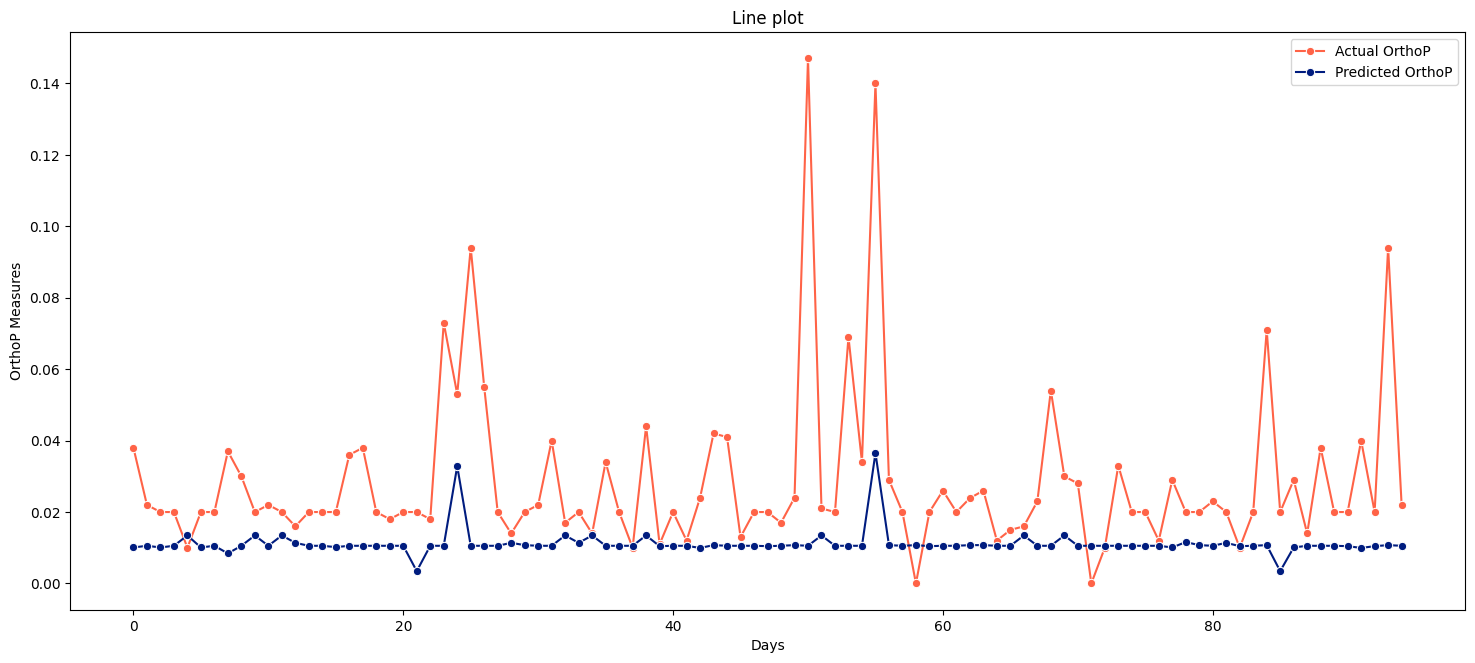

In [74]:
print(lightGBM_dfFinal['OrthoP'].min(), lightGBM_dfFinal['OrthoP'].max())
print(lightGBM_dfFinal['Predicted_OrthoP'].min(), lightGBM_dfFinal['Predicted_OrthoP'].max(), lightGBM_dfFinal['OrthoP'].mean(), lightGBM_dfFinal['Predicted_OrthoP'].mean())

if (len(lightGBM_dfFinal) > 25):
    lightGBM_df_reSample = lightGBM_dfFinal.sample(frac=0.6,random_state=1).reset_index(drop=False)
else:
    lightGBM_dfFinal_reSample = lightGBM_dfFinal

#custom_palette = sns.color_palette(["#FF6347", "#4682B4", "#32CD32"])
custom_palette = sns.color_palette(["#FF6347", "#4682B4"])

plt.figure(figsize=(18,7.5))

sns.lineplot({"Date": lightGBM_df_reSample['sampleDateOnly'], "Actual OrthoP" : lightGBM_df_reSample['OrthoP']}, markers=True, 
             palette=custom_palette)
ap = sns.lineplot({"Date": lightGBM_df_reSample['sampleDateOnly'], "Predicted OrthoP" : lightGBM_df_reSample['Predicted_OrthoP']}, markers=True,palette='dark')

# Set label for x-axis y-axis
ap.set(xlabel ="Days", ylabel = "OrthoP Measures", title ='Line plot')

plt.show()

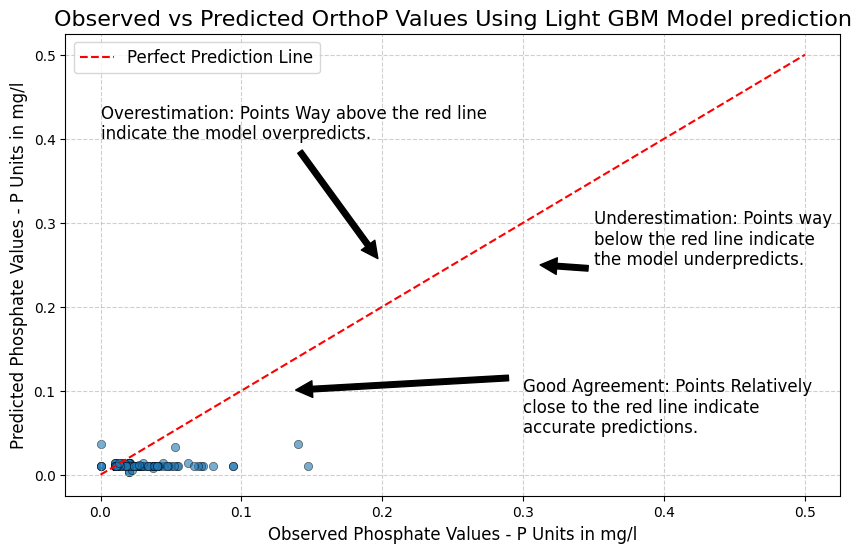

In [75]:
#*********************************************************************
# Create a scatter plot for Ground Truth Validation data *************
#*********************************************************************

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=y_predict, alpha=0.6, edgecolor='k')

# Add a 45-degree line to represent perfect predictions
#plt.plot([0, 10], [0, 10], 'r--', label='Perfect Prediction Line')
#plt.plot([0, 3], [0, 3], 'r--', label='Perfect Prediction Line')
plt.plot([0, 0.5], [0, 0.5], 'r--', label='Perfect Prediction Line')

# Add labels and title
plt.title('Observed vs Predicted OrthoP Values Using Light GBM Model prediction', fontsize=16)
plt.xlabel('Observed Phosphate Values - P Units in mg/l', fontsize=12)
plt.ylabel('Predicted Phosphate Values - P Units in mg/l', fontsize=12)

# Add annotations for key inferences
plt.annotate('Good Agreement: Points Relatively \nclose to the red line indicate \naccurate predictions.',
             #xy=(2, 2.5), xytext=(3, 1), fontsize=12,
             #xy=(0.6, 0.8), xytext=(0.9, 0.3), fontsize=12,
             xy=(0.13, 0.1), xytext=(0.3, 0.05), fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('Overestimation: Points Way above the red line\nindicate the model overpredicts.',
             #xy=(2.1, 2.7), xytext=(1.5, 2.4), fontsize=12,
             xy=(0.2, 0.25), xytext=(0.0, 0.4), fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('Underestimation: Points way \nbelow the red line indicate \nthe model underpredicts.',
             #xy=(2.7, 2.1), xytext=(2.1, 1.5), fontsize=12,
             xy=(0.31, 0.25), xytext=(0.35, 0.25), fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.05))

# Add a legend
plt.legend(loc='upper left', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [76]:
#Responsible AI - Begin

In [77]:
#Responsible AI
# Step 0: Install & Import required libraries for Shape testing
#pip install sklearn --user
#!pip install numpy | grep -v 'already'
!pip install shap | grep -v 'already' # Install SHAP if not already done
#!pip install --force-reinstall shap==0.44.0 lightgbm==4.1.0
#!conda install -c conda-forge shap -y


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [78]:
### **Fixed Code (Tested on Multiple SHAP Versions):**
import pickle
import shap
#import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import lightgbm as lgb

print("Step 1: Load pre-trained LightGBM model")

if (read_file_name == "input_template_orthop2959_pred_lgbm.csv"):
    model_pkl_file = "../03_prediction_model/pkls/LGBM_WithRMon_R1.pkl"
else:
    model_pkl_file = "../03_prediction_model/pkls/LGBM_WithoutRMon_R1.pkl"
    
with open(model_pkl_file, 'rb') as file:  
    lightGBM_sklearn = pickle.load(file)

print("Step 2: Extract the native LightGBM booster")
#model = lightGBM_sklearn.booster_
#lightGBM_sklearn.booster_.save_model('../NW_CodePP/model.txt')
#lightGBM_sklearn.booster_.save_model('../RDMAI_1C_OrthoP_R1/06_Saved_Model.txt')
lightGBM_sklearn.booster_.save_model('../03_prediction_model/pkls/LGBM_WithRMon_R1.txt')

#import lightgbm as lgbshpvalid
#model = lgb.Booster(model_file='../NW_CodePP/model.txt')
model = lgb.Booster(model_file='../03_prediction_model/pkls/LGBM_WithRMon_R1.txt')

print("Step 3: Load dataset (for background data)")
#data = pd.read_csv('water_catchment_data.csv')
print("Training Dataset (Used for Background Context) - When to Use")
print(" Global Explanations (how the model behaves overall) | Baseline Calculation (`explainer.expected_value`) | Feature Importance")
#Xsample = X_train.sample(frac=0.00009, random_state=42)
#Xsample = X_train.sample(frac=0.4, random_state=42)
#ysample = y_train[y_train.index.isin(Xsample.index)]

print("Test/Prediction/Validation/New Dataset (Used for Background Context) - When to Use")
print("Local Explanations (individual predictions) | Model Debugging (why specific predictions are wrong) | Domain Validation (do explanations align with expert knowledge?)")
Xvalid = X_valid #X_test
yvalid = y_valid #y_test


#print(len(Xsample), len(Xvalid), len(yvalid))
#Since we have loaded X and y already this step is commented


Step 1: Load pre-trained LightGBM model
Step 2: Extract the native LightGBM booster
Step 3: Load dataset (for background data)
Training Dataset (Used for Background Context) - When to Use
 Global Explanations (how the model behaves overall) | Baseline Calculation (`explainer.expected_value`) | Feature Importance
Test/Prediction/Validation/New Dataset (Used for Background Context) - When to Use
Local Explanations (individual predictions) | Model Debugging (why specific predictions are wrong) | Domain Validation (do explanations align with expert knowledge?)


Using 158 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


1. Load model
2. Create prediction wrapper
3. Initialize KernelExplainer with version-safe parameters
4. Get SHAP values : Highest variance


  0%|          | 0/1 [00:00<?, ?it/s]

5. Plot explanation for Visuals depicting the Influence of the Determinands in Model Training for OrthoP - Responsible AI


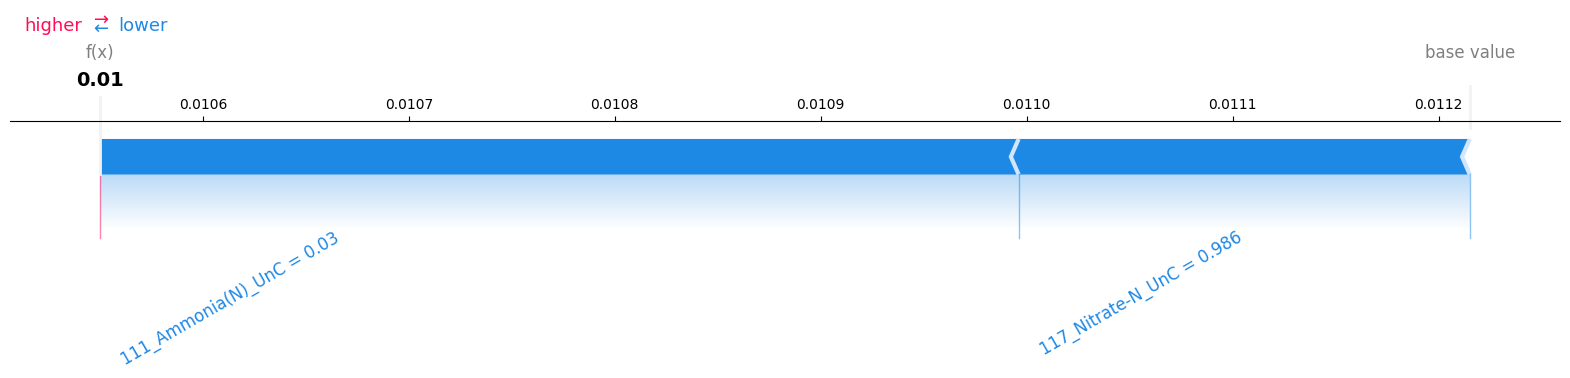

4. Get SHAP values : Lowest variance


  0%|          | 0/1 [00:00<?, ?it/s]

5. Plot explanation for Visuals depicting the Influence of the Determinands in Model Training for OrthoP - Responsible AI


/opt/conda/lib/python3.10/site-packages/shap/plots/_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


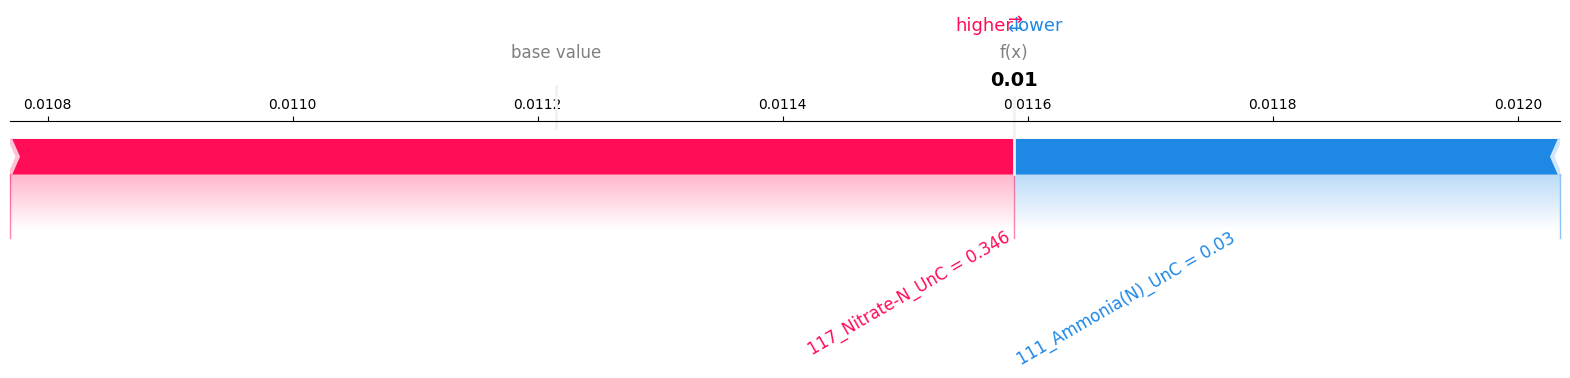

In [79]:
#*****************************************************************************
# ********* RESPONSIBLE AI - VALIDATION | PREDICTION EXPLAINATION. ***********
#*****************************************************************************

#import shap
#import lightgbm as lgb
#import pandas as pd

print("1. Load model")
#model_V = lgb.Booster(model_file='model.txt')
model_V = lgb.Booster(model_file='../03_prediction_model/pkls/LGBM_WithRMon_R1.txt')

print("2. Create prediction wrapper")
def lgb_predict_V(data):
    return model_V.predict(data.values if isinstance(data, pd.DataFrame) else data)

print("3. Initialize KernelExplainer with version-safe parameters")
try:
    # For SHAP >=0.41.0
    explainer = shap.KernelExplainer(
        model=lgb_predict_V, 
        data=Xvalid,    # Backgroud data (Supply Training or Validation data)
        link="identity"  # Use string instead of shap.links.identity
    )
except TypeError:
    # Fallback for older SHAP versions
    explainer = shap.KernelExplainer(
        model=lgb_predict_V, 
        data=Xvalid     # Backgroud data (Supply Training or Validation data)
    )

print("4. Get SHAP values : Highest variance")
shap_values_V = explainer.shap_values(Xvalid.iloc[[50]])
print("5. Plot explanation for Visuals depicting the Influence of the Determinands in Model Training for OrthoP - Responsible AI")
shap.force_plot(
    explainer.expected_value,
    shap_values_V,
    Xvalid.iloc[50], 
    feature_names=Xvalid.columns,
    matplotlib=True,
    text_rotation=30
)

print("4. Get SHAP values : Lowest variance")
shap_values_V_Low = explainer.shap_values(Xvalid.iloc[[62]])
print("5. Plot explanation for Visuals depicting the Influence of the Determinands in Model Training for OrthoP - Responsible AI")
shap.force_plot(
    explainer.expected_value,
    shap_values_V_Low,
    Xvalid.iloc[62], 
    feature_names=Xvalid.columns,
    matplotlib=True,
    text_rotation=30
)


#print("Step 6. Explain TEST predictions (predicted data)")
#shap_values_valid = explainer.shap_values(Xvalid)
#shap.decision_plot(explainer.expected_value, shap_values_valid, Xvalid)

#plt.gcf().set_size_inches(12,4) #Adjust the plot size
#plt.tight_layout()
#plt.show()

#Please ignore this comment section. These are developer notes for SHAP usage
#*****************************************************************************
# ****** RESPONSIBLE AI - GLOBAL PREDICTION EXPLANATION              *********
#*****************************************************************************

#Step to skip the cell if the Global Train dataset sample size is inadequate for Resp. AI analysis
if (len(Xsample) < 100000):
    %%skip #Skip cell execution
    print("Responsible AI for Global Train: Test predictions skipped...")
else:
    print("Running Responsible AI for Global Train: Test predictions...")
    
import shap
import lightgbm as lgb
import pandas as pd

print("1. Load model")
model = lgb.Booster(model_file='model.txt')

print("2. Create prediction wrapper")
def lgb_predict(data):
    return model.predict(data.values if isinstance(data, pd.DataFrame) else data)

print("3. Initialize KernelExplainer with version-safe parameters")
try:
    # For SHAP >=0.41.0
    explainer = shap.KernelExplainer(
        model=lgb_predict, 
        data=Xsample,    # Backgroud data (Supply Training or Validation data)
        link="identity"  # Use string instead of shap.links.identity
    )
except TypeError:
    # Fallback for older SHAP versions
    explainer = shap.KernelExplainer(
        model=lgb_predict, 
        data=Xsample     # Backgroud data (Supply Training or Validation data)
    )

print("4. Get SHAP values")
shap_values = explainer.shap_values(Xsample.iloc[[0]])

print("5. Plot explanation for Visuals depicting the Influence of the Determinands in Model Training for OrthoP - Responsible AI")
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    Xsample.iloc[0],
    feature_names=Xsample.columns,
    matplotlib=True,
    text_rotation=30
)

'''
print("6. Plot explanation for Visuals depicting the Influence of the Determinands in Model Training for OrthoP (using Alternate library) - Responsible AI")
shap.initjs()
shap.force_plot(
    explainer.expected_value, 
    shap_values[0], 
    Xsample.iloc[0],
    matplotlib=True,
    text_rotation=30
)
'''

#print("Step 7. Explain TEST predictions (predicted data)")
#shap_values_valid = explainer.shap_values(Xvalid)
#shap.decision_plot(explainer.expected_value, shap_values_valid, Xvalid)

#plt.gcf().set_size_inches(12,4) #Adjust the plot size
#plt.tight_layout()
#plt.show()

In [80]:
#Critical step to calculate shap value for overall prediction
shap_values_V_Full = explainer.shap_values(Xvalid)
#print(shap_values_valid)

  0%|          | 0/158 [00:00<?, ?it/s]

Explainer expected value: [0.01570675]
SHAP Decision PLOT using entire Validation dataset


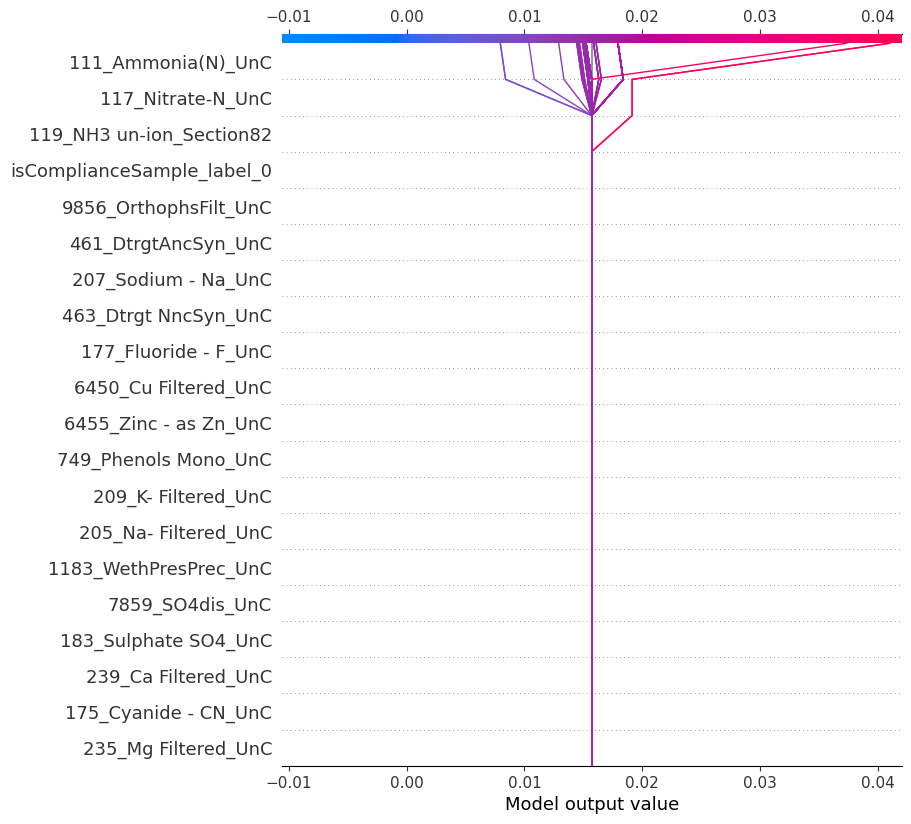

In [81]:
#Various decision plots
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html
#Sample 1

import warnings
warnings.filterwarnings('ignore')

explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(len(Xvalid)) # 197 observations
features = Xvalid.iloc[select]
features_display = Xvalid.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

print("SHAP Decision PLOT using entire Validation dataset")
shap.decision_plot(explainer.expected_value, shap_values_V_Full, Xvalid)

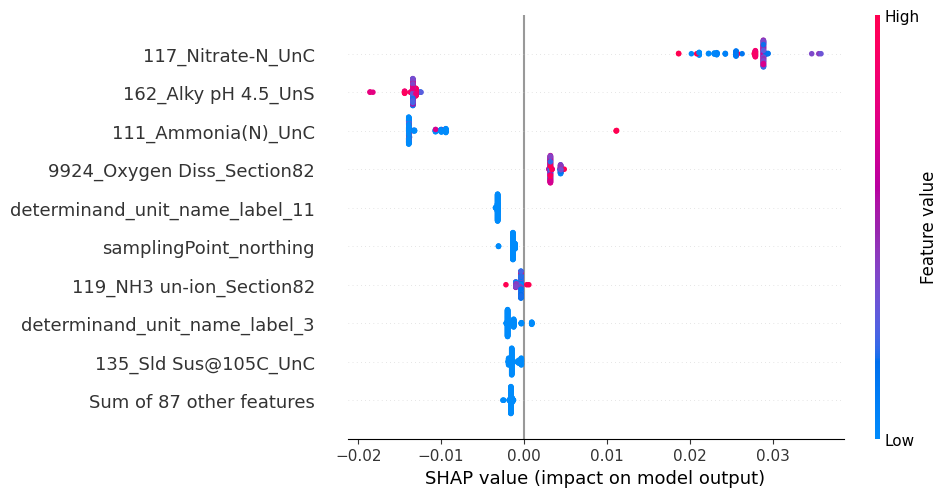

In [82]:
#as requested by WRC, beeswarm plot is generated

'''
# compute SHAP values
explainer_bee = shap.TreeExplainer(model)
shap_values_bee = explainer_bee.shap_values(X_valid)

#Plot beeswarm
plt.figure(figsize=(12,8))
shap.summary_plot(shap_values_bee,
                  X_valid, 
                  feature_names=Xvalid.columns,
                  plot_type="dot", #Creates beeswarm plot
                  #color="coolwarm",
                  #alpha=0.9,
                  show=False)

#better plot appearance
ax=plt.gca()
ax.set_xlabel("SHAP value (Impact on Prediction)", fontsize=12, labelpad=15)
ax.set_ylabel("Features", fontsize=12, labelpad=15)
plt.title ("Beeswarm Plot of SHAP values", fontsize=16, pad=20)

#X-axis adjustments for more space
#xlim=abs(max(ax.get_xlim(), key=abs))[1] * 1.2 #add 20% extra space
#plt.xlim(-xlim, xlim)
c_xlim=ax.get_xlim()
max_abs=max(abs(c_xlim[0]), abs(c_xlim[1]))
plt.xlim(-max_abs * 1.2, max_abs * 1.2)

#adding grid lines for readability
ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.9)

#Colorbars
cbar = plt.colorbar(label='Feature value', pad=0.01)
cbar.set_label('Feature value (Low to High)', size=12)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
'''

# compute SHAP values
explainer_bee2 = shap.Explainer(model)
shap_values_bee2 = explainer(X_valid)
#shap.plots.beeswarm(shap_values_bee2, max_display=100)
shap.plots.beeswarm(shap_values_bee2, order=shap_values_bee2.abs.max(0))


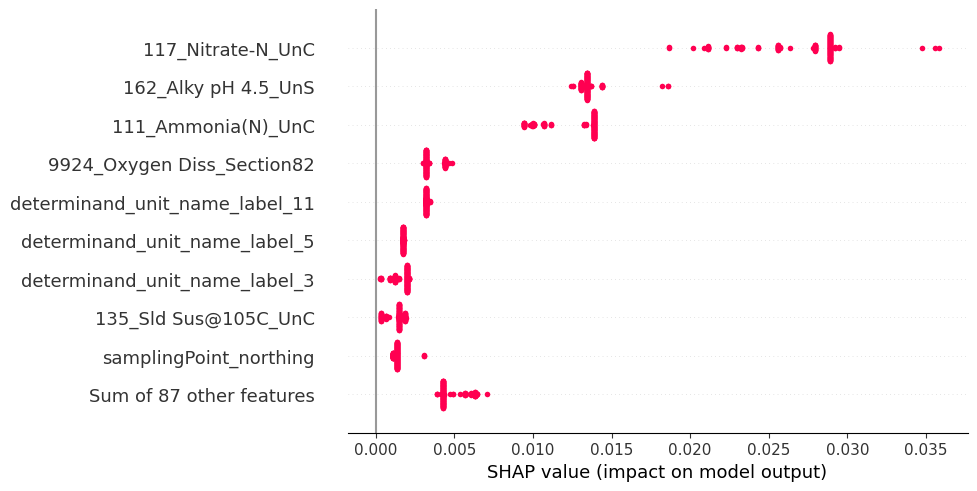

In [83]:
#continuity to the above code cell 
shap.plots.beeswarm(shap_values_bee2.abs, color="shap_red")


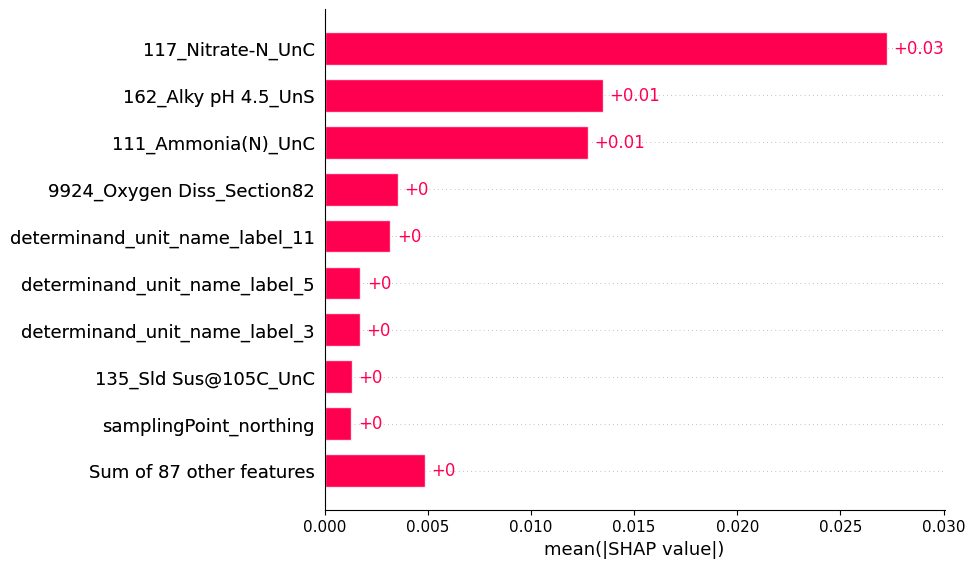

In [84]:
#continuity to the above code cell 
shap.plots.bar(shap_values_bee2.abs.mean(0))


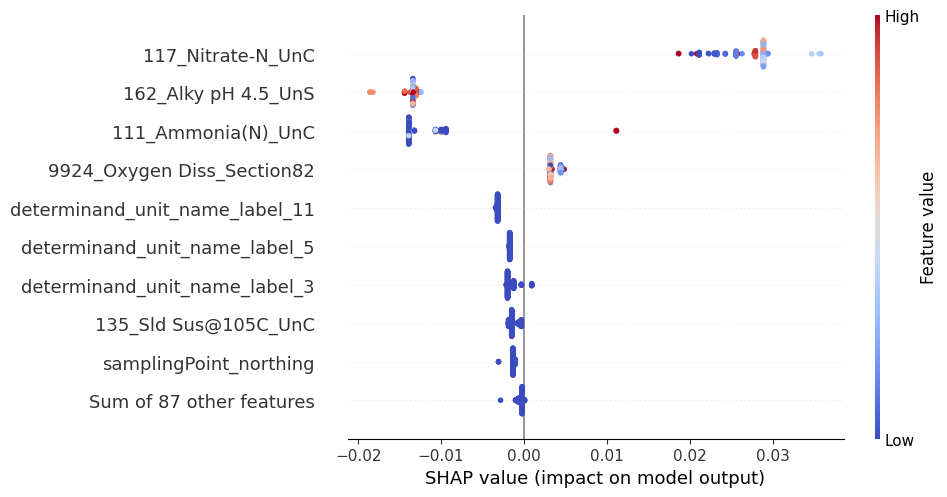

In [85]:
#continuity to the above code cell 
shap.plots.beeswarm(shap_values_bee2, color=plt.get_cmap("coolwarm"))


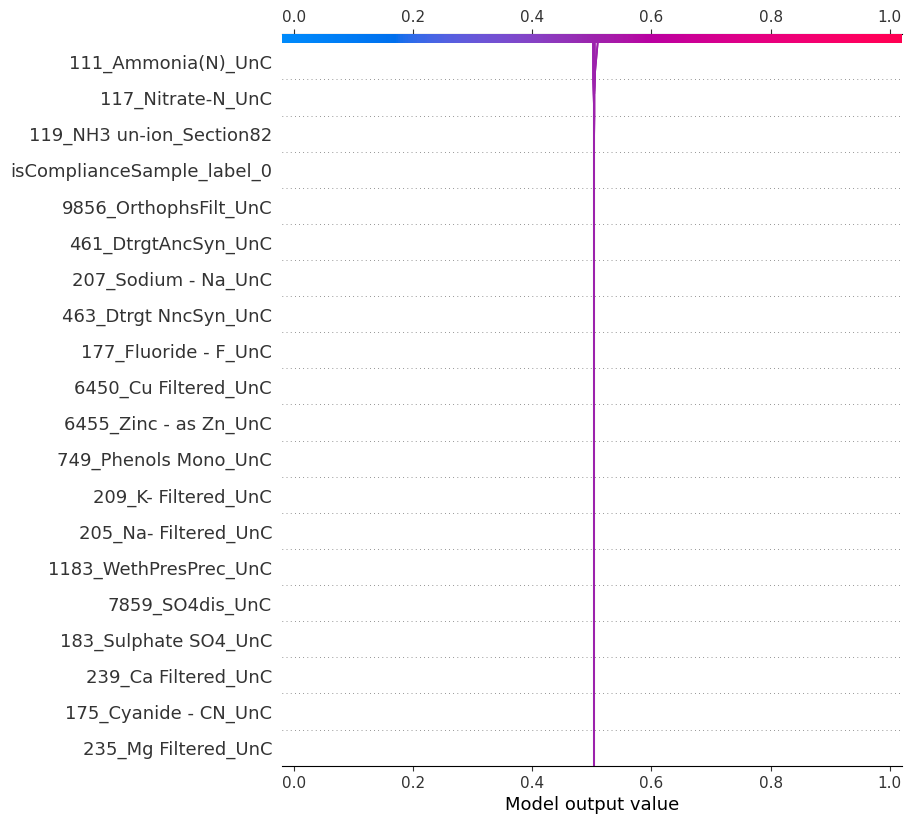

In [86]:
#Various decision plots
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html
#Sample 2

shap.decision_plot(expected_value, shap_values_V_Full, features_display, link="logit")


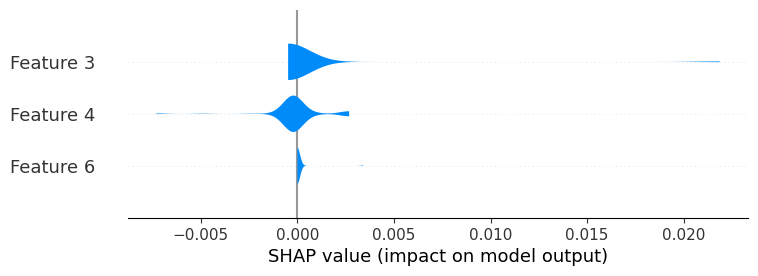

In [87]:
#Violin plots Feature Importance
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/violin.html
#Sample 3

feat_names = list(Xvalid.columns)
#ZeroDivisionError: division by zero:- Please note change the max_display to a number that does not give the error. Here 11 works 
#good as there are 11 influential features 
#shap.plots.violin(shap_values_V_Full, features=Xvalid, max_display=11, feature_names=feat_names, plot_type="layered_violin")

#shap.plots.violin(shap_values_V_Full, features=Xvalid, max_display=7, feature_names=feat_names, plot_type="layered_violin")

#shap.plots.violin(shap_values_V_Full, feature_names=feat_names)
shap.plots.violin(shap_values_V_Full, max_display=3)
#shap.plots.violin(shap_values_V_Full)


In [88]:
'''
SHAP Documentation
1.Baseline Value (`explainer.expected_value`): 
    This is the average predicted orthophosphate level across all water samples. Your specific catchment’s prediction starts from this baseline.

2. Feature Contributions (Red/Blue Bars): 
   - Red (Positive Impact): 
     Factors pushing orthophosphate levels higher than average. For example, high agricultural runoff (+X mg/L) suggests fertilizer use may be contributing
   - Blue (Negative Impact): 
     Factors pulling levels lower than average. For example, low pH (-Y mg/L) might indicate reduced phosphate solubility due to acidity.

3. Critical Features: 
   The largest bars show the most influential factors. If turbidity is a top driver, sediment-bound phosphate transport could be a key process in your catchment.

#### Domain-Specific Interpretation Template: 
 The model predicts your catchment’s orthophosphate level at {predicted_value} mg/L (vs. average {baseline} mg/L). 
 Key drivers:
 +{value} mg/L from {feature} (e.g., heavy rainfall increasing agricultural runoff) 
 -{value} mg/L from {feature} (e.g., recent water treatment reducing industrial discharge) 
 This aligns with known phosphate dynamics where {domain_insight} 

### Actionable Insights for Water Experts: 
1. Prioritize Monitoring: Focus on top 3 features from the plot (e.g., nitrate levels, flow rate). 
2. Validate Mechanistically: Check if high-impact features match known catchment processes (e.g., septic system leaks if "proximity_to_housing" is significant). 
3. Mitigation Strategies: 
   - If pH is a major driver, suggest limting to adjust acidity. 
   - If flow_rate dominates, recommend riparian buffers to slow runoff. 

# Example Output with Labels & Interpretation: 
Interpretation: 
 Predicted orthophosphate is 0.18 mg/L (above baseline 0.12 mg/L). The increase is primarily due to high nitrate levels (+0.04 mg/L) from farm 
    runoff and low dissolved oxygen (+0.02 mg/L) reducing phosphate binding. The water treatment plant’s 
    recent filtration upgrade (-0.01 mg/L) partially offset this rise
'''

'\nSHAP Documentation\n1.Baseline Value (`explainer.expected_value`): \n    This is the average predicted orthophosphate level across all water samples. Your specific catchment’s prediction starts from this baseline.\n\n2. Feature Contributions (Red/Blue Bars): \n   - Red (Positive Impact): \n     Factors pushing orthophosphate levels higher than average. For example, high agricultural runoff (+X mg/L) suggests fertilizer use may be contributing\n   - Blue (Negative Impact): \n     Factors pulling levels lower than average. For example, low pH (-Y mg/L) might indicate reduced phosphate solubility due to acidity.\n\n3. Critical Features: \n   The largest bars show the most influential factors. If turbidity is a top driver, sediment-bound phosphate transport could be a key process in your catchment.\n\n#### Domain-Specific Interpretation Template: \n The model predicts your catchment’s orthophosphate level at {predicted_value} mg/L (vs. average {baseline} mg/L). \n Key drivers:\n +{value

In [89]:
#Other Plots
'''
# 1. Initialize explainer with TRAINING data
explainer = shap.TreeExplainer(model, X_train.sample(100))

# 2. Global analysis (training data)
shap.summary_plot(explainer.shap_values(X_train), X_train)

print("Step 3. Explain TEST predictions (predicted data)")
shap_values_test = explainer.shap_values(X_test)
shap.decision_plot(explainer.expected_value, shap_values_test,  X_test)
shap.summary_plot(explainer.shap_values(X_train), X_test)
'''
### **Common Mistakes to Avoid**
#| Mistake                                      | Consequence                             | Fix                                                       |
#|----------------------------------------------|-----------------------------------------|-----------------------------------------------------------|
#| Using test data as `data` in `TreeExplainer` | Biased baseline values                  | Always use training data for the explainer background     |
#| Explaining training predictions only         | Overlooks model behavior on unseen data | Use test/new data for local explanations                  |
#| Not sampling large training data             | Slow SHAP computations                  | Use `X_train.sample(1000)`                                |

'\n# 1. Initialize explainer with TRAINING data\nexplainer = shap.TreeExplainer(model, X_train.sample(100))\n\n# 2. Global analysis (training data)\nshap.summary_plot(explainer.shap_values(X_train), X_train)\n\nprint("Step 3. Explain TEST predictions (predicted data)")\nshap_values_test = explainer.shap_values(X_test)\nshap.decision_plot(explainer.expected_value, shap_values_test,  X_test)\nshap.summary_plot(explainer.shap_values(X_train), X_test)\n'

In [90]:
#Final Checks
#Data Validation
print("Missing values: ", Xvalid.isnull().sum().sum())    #must be zero
#print("Infinite values: ", np.isinf(Xp.values).sum()) #must be zero

#Version verification
print ("SHAP version: ", shap.__version__)   #should be >- 0.41.0
print("LightGBM version: ", lgb.__version__) #should be >= 4.0.0

#Model Sanity Check
print(model.predict(Xvalid.iloc[[0]])) #Should return valid predictions

#Missing values:  0
#SHAP version:  0.47.2
#LightGBM version:  4.5.0
#[0.05070975]

Missing values:  0
SHAP version:  0.47.2
LightGBM version:  4.5.0
[0.01055017]


In [91]:
#Responsible AI - End

In [92]:
showtime()
#END CARD

27 July 2025 11:39:27


()

In [93]:
#End CARD
#In line comments completed 10-May-2025. The program shall be tuned continuously until the end of May 2025.

In [94]:
#exit() Uncomment if you need to release the compute resources used in the above executions